### Packages

In [5]:
#!pip install geopanda
#!pip install torch
#!pip install tslearn

In [12]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

from torch.nn import functional
from torch.autograd import Variable

import statistics

#temporal pattern clustering
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from sklearn import metrics

#!pip install dtaidistance
#!pip install plotly
#!pip install tslearn
#source https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html
#from dtaidistance import dtw
#from dtaidistance import dtw_visualisation as dtwvis

from scipy.cluster.hierarchy import fcluster
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

#regression model
#from patsy import dmatrices
#import statsmodels.api as sm

from datetime import datetime

#from pysal.model import spreg
#from pysal.lib import weights
#from pysal.explore import esda

#calculate the demographic bias 
#use wasserstein_distance
from scipy.stats import wasserstein_distance

#path = 'C:/Users/29700/Downloads/RecSys-Workshop/tutorials/'
#os.chdir(path)
#import utilities as utl

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae
from datetime import datetime
import time
from sklearn.decomposition import NMF

import time
import scipy.sparse
from scipy.stats import entropy
from sys import exit

import itertools
from itertools import permutations

import math

import ast

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae

from numpy.linalg import svd
from scipy.sparse import csc_matrix, diags

from scipy.sparse.linalg import svds

In [13]:
#function
#read latlon id with home identified
def read_data(filepath, homepath, combine_dt):
    #read ids with home identified
    id_withhome = pd.read_csv(homepath, header=None, sep='\t')
    id_withhome.columns = ['newid','lat','lon']
    if combine_dt == True:
        id_latlon = pd.read_csv(filepath, header=0, sep=',')
        #get ids
        homeids = list(np.unique(id_withhome.newid))
        id_latlon = id_latlon[id_latlon.newid.isin(homeids)]
        return(id_latlon)
    else:
        return(id_withhome)
    #print(id_latlon.head(3))
    
def convert_to_shp(filepath, homepath, combine_dt=True):
    points = read_data(filepath, homepath, combine_dt)
    geo_points = gpd.GeoDataFrame(points,
                                 geometry=gpd.points_from_xy(points['lon'],\
                                                           points['lat']),\
                                crs={'init': 'epsg:4326'})
    return(geo_points)

#make sure the default crs for zone file is espg4326
def spatial_join(zone_path, points):
    Zone = gpd.read_file(zone_path)
    Zone.crs = points.crs
    points = gpd.tools.sjoin(points, Zone, how='right')
    return(points)

#conduct a small test to make sure the spatial join works
def small_sjoin_test(zonepath, data, key_col):
    test_dt = spatial_join(zonepath, data.iloc[:15])
    geoid = np.unique(test_dt[key_col])
    if 'nan' in geoid:
        print('join not successfully')
        print(geoid)
    else:
        print(geoid)
    return(test_dt)
    
#plot zone and points to make sure they are in the same projection
def plot_point_zone(zone_path, points):
    zone = gpd.read_file(zone_path)
    base = zone.plot(color='white', edgecolor='grey')
    points.plot(ax=base, marker='o', color='red', markersize=5)
    
#check null data after spatial join
def checknull(data_shape, zone_path, savepath, save_index=True):
    data_shape['geoid'] = data_shape['GEOID10'].tolist()
    null_Data = data_shape[data_shape['geoid'].isnull()]
    print(len(null_Data['geoid']))
    plot_point_zone(zone_path, null_Data)
    if save_index == True:
        null_Data.to_csv(savepath)

### Spatial join process

In [ ]:
#PREVIOUS CODE
paths = 'G:/My Drive/2021/Bias/PSRC_od_simulation_2018/'
input_path = paths+'taz2010_revised.shp'
taz = gpd.read_file(input_path)

home_shp = convert_to_shp('G:/', 'cuebiq_home_psrc_raw.csv', combine_dt=False)
home_withtaz = spatial_join(input_path, home_shp)

home_withtaz.to_csv(paths+'home_psrc_withtaz.csv')

#get Seattle home ids
home_withct = spatial_join('spatial_check/Seattle_ct2010.shp', home_shp)
Seattle_homeids = sorted(home_withct['newid'].values)

latlon_shape_ct = latlon_shape_ct[~latlon_shape_ct['GEOID10'].isnull()]
latlon_shape_ct.shape

In [14]:
#get_data('withobs04052017.csv','cuebiq_home_psrc_raw.csv','spatial_check/ct2010.shp')

def get_new_hr_minut(hr, minut):
    min_index = math.ceil(minut/5)
    if min_index != 12:
        return(hr, min_index*5)
    else: 
        if hr+1 != 24:
            return(hr+1, 0)
        else: 
            return(0, 0)
    
def get_total_locts(obs_data):
    locts = {}
    num_index = 0
    for geoid in np.unique(obs_data['GEOID10']):
        for hr in range(24):
            for minut in np.unique(obs_data['min_5']):
                a = str(geoid)+'_'+str(hr)+'_'+str(minut)
                locts[a] = num_index
                num_index += 1
    nb_locts = len(locts)
    return(locts, nb_locts)

def get_data(obs_data_file, home_file, zone_file, newids, newid_dict):
    latlon_shape = convert_to_shp(obs_data_file, home_file)
    print('original data shape', latlon_shape.shape)
    latlon_shape = spatial_join(zone_file, latlon_shape)
    print('data shape after data join', latlon_shape.shape)
    latlon_shape = latlon_shape[~latlon_shape['GEOID10'].isnull()]
    print('data shape after deleting nulls',latlon_shape.shape)
    
    #summary the obs
    #revise the data, revised as 5-min 
    new_hr = []
    minut_5 = []
    for hr, minut in latlon_shape[['hr', 'minut']].values:
        h, min_5 = get_new_hr_minut(hr, minut)
        new_hr.append(h)
        minut_5.append(min_5)
    
    latlon_shape['newh'] = new_hr
    latlon_shape['min_5'] = minut_5

    group_col = ['newid','GEOID10', 'd', 'newh', 'min_5']
    latlon_shape = latlon_shape[['newid','GEOID10', 'd', 'newh', 'min_5', 'obs']].groupby(by=group_col).sum()
    latlon_shape.reset_index(inplace=True)
    latlon_shape.sort_values(by=group_col)
    
    cur_newids = list(np.unique(latlon_shape['newid']))
    add_ids = []
    for ids in cur_newids:
        if ids not in newids:
            newids.append(ids)
            add_ids.append(ids)
    n_newid = len(newids)
    
    if add_ids != []:
        cur_index = len(newid_dict)
        for ids in add_ids:
            newid_dict[ids] = cur_index 
            cur_index += 1
    
    stids, n_stid = get_total_locts(latlon_shape)
    latlon_shape['stids'] = latlon_shape['GEOID10']+'_'+latlon_shape['newh'].astype(str)+'_'+latlon_shape['min_5'].astype(str)
    
    obs_matrix = np.zeros((n_newid, n_stid))
    for ids, stid, obs in latlon_shape[['newid', 'stids', 'obs']].values:
        obs_matrix[newid_dict[ids], stids[stid]] = obs
    
    print('generate obs matrix shape', obs_matrix.shape)
    path = 'G:/My Drive/2021/Bias/SUMO_simulation/'
    savefile = 'obsmx'+obs_data_file[7:-4]+'.csv'
    pd.DataFrame(obs_matrix).to_csv(path+savefile)
    
    return(newids, newid_dict)

In [ ]:
#get cuebiq data file name ('withobs04052017.csv')
obs_csv_file = []
for i in os.listdir():
    if 'withobs' in i:
        obs_csv_file.append(i)

#GET THE DATA
newids = []
newid_dict = {}
for obs_file in obs_csv_file:
    newids, newid_dict = get_data(obs_file, 'cuebiq_home_psrc_raw.csv', 'spatial_check/Seattle_ct2010.shp', newids, newid_dict) 
    
with open('newid_tsid_aggregation.txt', 'w') as f:
    f.write(str(newid_dict))
    f.write(str(stids))
f.close()

#n_user = len(newids)
def get_agg_matrix(input_path, n_user, obs_matrix, first_input=True):
    cur_obs_matrix = pd.read_csv(input_path, index_col=0).to_numpy()
    
    cur_n_user, n_sid = cur_obs_matrix.shape
    #print('current obs matrix shape', cur_obs_matrix.shape)
        
    if cur_n_user != n_user:
        diff_n_user = int(n_user-cur_n_user)
        filled_zero_matrix = np.zeros((diff_n_user, n_sid))
        cur_obs_matrix = np.vstack([cur_obs_matrix, filled_zero_matrix])
        #print('revised matrix shape', cur_obs_matrix.shape)
    if first_input == False:
        obs_matrix_revised = obs_matrix + cur_obs_matrix
    else:
        obs_matrix_revised = cur_obs_matrix
    return(obs_matrix_revised)

#get_sum_matrix 
input_path = 'G:/My Drive/2021/Bias/SUMO_simulation/' 
matrixfile = []
for i in os.listdir(input_path):
    if 'obsmx' in i:
        matrixfile.append(i)
        
obs_mx = 0
for mxfile in matrixfile:
    filepath = input_path + mxfile
    if obs_mx == 0:
        obs_matrix_sum = get_agg_matrix(filepath, n_user, obs_mx, True)
        obs_mx = 1
        #print('matrixfile cur obs matrix shape', obs_matrix_sum.shape)
    else:
        obs_matrix_sum = get_agg_matrix(filepath, n_user, obs_matrix_sum, False)
        #obs_mx = obs_matrix.copy()
        #print('matrixfile cur obs matrix shape', obs_matrix_sum.shape)

In [286]:
#test_matrix = pd.read_csv('G:/My Drive/2021/Bias/SUMO_simulation/obsmx04272017.csv', index_col=0).to_numpy()

In [265]:
#obs_matrix = pd.read_csv('G:/My Drive/2021/Bias/SUMO_simulation/obsmx04042017.csv', index_col=0).to_numpy()

In [7]:
os.chdir('G:/My Drive/2021/Bias/SUMO_simulation')

obs_matrix_sum = pd.read_csv('obs_matrix_sum.csv', index_col=0).to_numpy()
#obs_matrix_sum.head(3)

ids_list = []
with open('G:/My Drive/2021/Bias/SUMO_simulation/newid_tsid_aggregation.txt', 'r') as f:
    ids_list.append(f.readlines())
    
newids = ast.literal_eval(str(ids_list[0][0].split('}')[0]+'}'))
tsids = ast.literal_eval(ids_list[0][0].split('}')[1]+'}')

In [441]:
#since it is known that we have 24715 data
nrow = obs_matrix_sum.shape[0]
def get_obs_byday(obs_file, obs_matrix, first_file=0):
    cur_matrix = pd.read_csv(obs_file, index_col=0).to_numpy()
    cur_row, cur_col = cur_matrix.shape
    if cur_row < nrow:
        add_zeros = np.zeros((int(nrow-cur_row), cur_col))
        cur_matrix = np.vstack((cur_matrix, add_zeros))
    if first_file == 0:
        obs_matrix = cur_matrix
    else:
        obs_matrix = np.hstack((obs_matrix, cur_matrix))
    return(obs_matrix)

#file_name = []
#for i in os.listdir():
#    if 'obsmx' in i:
#        file_name.append(i)

#first_file_index = 0
#obs_matrixbyday = 0
#for obsfile in file_name:
#    obs_matrixbyday = get_obs_byday(obsfile, obs_matrixbyday, first_file_index)
#    first_file_index = 1

In [445]:
print(obs_matrixbyday.shape)
print(1- np.count_nonzero(obs_matrixbyday)/(len(obs_matrixbyday.flatten())))

(24715, 41472)
0.9987985556563965


In [447]:
#pd.DataFrame(obs_matrixbyday).to_csv('obs_matrixbyday.csv')

In [7]:
obs_matrix_sum.shape
#calculate sparsity
1- np.count_nonzero(obs_matrix_sum)/(len(obs_matrix_sum.flatten()))

0.9906151071286743

In [8]:
obs_matrix_mean = obs_matrix_sum/12

In [360]:
#pd.DataFrame(obs_matrix_sum).to_csv(input_path+'obs_matrix_sum.csv')

In [9]:
len(np.count_nonzero(obs_matrix_mean, axis=1))

24715

In [33]:
k = 100
a = 0.1
maxiterations = 10000
l1_r = 0.1
model = NMF(n_components=k,  alpha=a, max_iter=maxiterations,
            l1_ratio=l1_r)
W = model.fit_transform(obs_matrix_sum)
H = model.components_
WH = np.dot(W, H)

print(mean_squared_error(obs_matrix_sum, WH, squared=False))
print(np.count_nonzero(WH)/np.count_nonzero(obs_matrix_sum))

C:\Users\29700\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


0.3384356916635767
88.3777518023081


In [31]:
model_results = pd.read_csv('model_results.csv', index_col=0)
model_results = model_results.to_numpy()

In [32]:
model_results = list(model_results)

In [67]:
def get_model_results_nmf(k_range, a, l1_r, maxiterations, obs_matrix_sum, savepath):
    model_results = []
    for k in k_range:
        for a_val in a:
            for l1_rval in l1_r:
                cur_results = [k, a_val, l1_rval]
                model = NMF(n_components= k,  
                            alpha=a_val, 
                            max_iter=maxiterations,
                            l1_ratio=l1_rval)
                W = model.fit_transform(obs_matrix_sum)
                H = model.components_
                WH = np.dot(W, H)
                rmse_val = mean_squared_error(obs_matrix_sum, WH, squared=False)
                non_zero_ratio = np.count_nonzero(WH)/np.count_nonzero(obs_matrix_sum)
                cur_results.append(rmse_val)
                cur_results.append(non_zero_ratio)
                #print(cur_results)
                model_results.append(cur_results)
                
    model_results = pd.DataFrame(np.array(model_results))
    model_results.columns = ['k', 'alpha', 'l1_ratio', 'rmse', 'non_zero_rate']
    model_results.to_csv(savepath)

#no reg
#0.37628660040841405
#88.86168977222118

#with open('G:/My Drive/2021/Bias/SUMO_simulation/model_results.csv', 'a') as f:
#index_val = 0
#for val in model_results:
#    model_results[index_val] = list(model_results[index_val])
#    index_val += 1


In [169]:
k_range = [10, 20, 50, 100, 120, 150, 200]
#k_range = [100, 120, 150, 200]
a = [.1, .2, .5, .6, .9]
l1_r = a
#model_results = []
maxiterations = 3000
input_path = 'G:/My Drive/2021/Bias/SUMO_simulation/model_results.csv'

#get_model_results_nmf(k_range, a, l1_r, maxiterations, obs_matrix_sum, input_path)

In [ ]:
folderpath = 'G:/My Drive/2021/Bias/SUMO_simulation/'

input_path = folderpath+'model_results_nmf_larger5.csv'
del_col = np.where(np.count_nonzero(obs_matrix_sum, axis=1)<=5)[0]
obs_matrix_sum_del = np.delete(obs_matrix_sum, del_col, 0)
get_model_results_nmf(k_range, a, l1_r, maxiterations, obs_matrix_sum_del, input_path)

C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\Yiran\anaconda3\lib\sit

In [ ]:
folderpath = 'G:/My Drive/2021/Bias/SUMO_simulation/'
input_path = folderpath+'model_results_nmf_larger10.csv'

del_col = np.where(np.count_nonzero(obs_matrix_sum, axis=1)<=10)[0]
obs_matrix_sum_del = np.delete(obs_matrix_sum, del_col, 0)

get_model_results_nmf(k_range, a, l1_r, maxiterations, obs_matrix_sum_del, input_path)

In [15]:
#svd method
def get_model_results_svd(input_matrix, return_pred=False):
    u, s, vh = svd(obs_matrix_sum, full_matrices=False)
    pred_matrix = np.dot(u*s, vh)
    rmse_val = mean_squared_error(input_matrix, pred_matrix, squared=False)
    print(np.allclose(pred_matrix, input_matrix, atol=1e-2))
    if return_pred == False:
        return(rmse_val)
    else:
        return(rmse_val, pred_matrix)

def get_model_results_svds(input_matrix, k_val, return_pred=False):
    u, s, vt = svds(input_matrix, k=k_val)
    pred_matrix = u @ np.diag(s) @ vt
    print(np.allclose(pred_matrix, input_matrix, atol=1e-2))
    rmse_val = mean_squared_error(input_matrix, pred_matrix, squared=False)
    if return_pred == False:
        return(rmse_val)
    else:
        return(rmse_val, pred_matrix)

'''    
with open(folderpath+'svd.txt', 'a') as f:
    f.write('obs_matrix,'+str(get_model_results_svd(obs_matrix_sum))+'\n')
    
    del_col = np.where(np.count_nonzero(obs_matrix_sum, axis=1)<=5)[0]
    obs_matrix_sum_del = np.delete(obs_matrix_sum, del_col, 0)
    f.write('obs_matrix_larger5,'+str(get_model_results_svd(obs_matrix_sum_del))+'\n')
    
    del_col = np.where(np.count_nonzero(obs_matrix_sum, axis=1)<=10)[0]
    obs_matrix_sum_del = np.delete(obs_matrix_sum, del_col, 0)
    f.write('obs_matrix_larger10,'+str(get_model_results_svd(obs_matrix_sum_del))+'\n')

f.close()
'''

#obs_matrix_pred_svd
#convert negative val 
def normalize_mtx(input_matrix):
    max_val = np.multiply(np.max(input_matrix, axis=1).reshape(input_matrix.shape[0], 1), np.ones(input_matrix.shape))
    min_val = input_matrix - np.multiply(np.min(input_matrix, axis=1).reshape(input_matrix.shape[0], 1),  np.ones(input_matrix.shape))
    norm_val = np.multiply(max_val, np.divide(min_val, np.ptp(input_matrix, axis=1).reshape(input_matrix.shape[0], 1)))
    return(norm_val)

"    \nwith open(folderpath+'svd.txt', 'a') as f:\n    f.write('obs_matrix,'+str(get_model_results_svd(obs_matrix_sum))+'\n')\n    \n    del_col = np.where(np.count_nonzero(obs_matrix_sum, axis=1)<=5)[0]\n    obs_matrix_sum_del = np.delete(obs_matrix_sum, del_col, 0)\n    f.write('obs_matrix_larger5,'+str(get_model_results_svd(obs_matrix_sum_del))+'\n')\n    \n    del_col = np.where(np.count_nonzero(obs_matrix_sum, axis=1)<=10)[0]\n    obs_matrix_sum_del = np.delete(obs_matrix_sum, del_col, 0)\n    f.write('obs_matrix_larger10,'+str(get_model_results_svd(obs_matrix_sum_del))+'\n')\n\nf.close()\n"

In [ ]:
svd_results = []
for k_val in k_range:
    rmse_svds = get_model_results_svds(obs_matrix_sum, k_val)
    svd_results.append([k_val, rmse_svds])

In [161]:
obs_matrix_pred_svd_norm = normalize_mtx(obs_matrix_pred_svd)
rmse_svd, obs_matrix_pred_svd = get_model_results_svd(obs_matrix_sum, return_pred=True)
rmse_svds, obs_matrix_pred_svds = get_model_results_svds(obs_matrix_sum, k_val, return_pred=True)

obs_matrix_pred_svd_norm = normalize_mtx(obs_matrix_pred_svd)
obs_matrix_pred_svds_norm = normalize_mtx(obs_matrix_pred_svds)
mean_squared_error(obs_matrix_sum, obs_matrix_pred_svds_norm, squared=False)

In [178]:
model_results = pd.read_csv('model_results.csv', index_col=0)

In [183]:
model_results.sort_values(by=['k','alpha','l1_ratio'])

,k,alpha,l1_ratio,rmse,non_zero_rate
0,10.0,0.1,0.1,0.389926,90.939598
1,10.0,0.1,0.2,0.389926,90.208907
2,10.0,0.1,0.5,0.389926,88.418481
3,10.0,0.1,0.6,0.389926,87.929569
4,10.0,0.1,0.9,0.389926,86.616459
...,...,...,...,...,...
170,200.0,0.9,0.1,0.312842,82.991414
171,200.0,0.9,0.2,0.312626,79.540341
172,200.0,0.9,0.5,0.313106,72.176395
173,200.0,0.9,0.6,0.313720,70.076871


In [186]:
model_results[model_results['rmse'] == min(model_results['rmse'])]

,k,alpha,l1_ratio,rmse,non_zero_rate
165,200.0,0.6,0.1,0.312143,85.406879


In [250]:
model = NMF(n_components= 200,  alpha=.6, max_iter=3000, l1_ratio=.1)
W = model.fit_transform(obs_matrix_sum)
H = model.components_
WH = np.dot(W, H)
rmse_val = mean_squared_error(obs_matrix_sum, WH, squared=False)
#pd.DataFrameFrame(WH).to_csv('WH_obs_2000601.csv')

C:\Users\29700\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [458]:
nmf_results0405 = pd.read_csv('nmf_est_result_0405obs.csv')
nmf_results0405.columns = ['Zero_index', 'k', 'L1Ratio', 
                           'alphaW', 'alphaH','ZeroWeight',
                           'MaxIter', 'RandState', 'ZeroPer', 
                           'NonZeroNum', 'RMSE', 'MAE','RunTime']

In [11]:
nmf_result_byday = pd.read_csv('obs_byday_model_results.csv', index_col = 0)
nmf_result_byday[nmf_result_byday['rmse']==min(nmf_result_byday['rmse'])]

,k,alpha,l1_ratio,rmse,non_zero_rate
158,200.0,0.2,0.6,0.080223,568.078936


In [473]:
print(nmf_results0405[nmf_results0405['Zero_index']==0].sort_values(by=['RMSE']).iloc[:1])
print(nmf_results0405[nmf_results0405['RMSE']==min(nmf_results0405['RMSE'])])

    Zero_index   k  L1Ratio  alphaW  alphaH  ZeroWeight  MaxIter  RandState  \
33           0  18      0.0     0.0     0.0         0.0     1000         42   

     ZeroPer  NonZeroNum      RMSE       MAE  RunTime  
33  0.999309       304.0  0.149163  0.038237      NaN  
     Zero_index   k  L1Ratio  alphaW  alphaH  ZeroWeight  MaxIter  RandState  \
887           1  78      0.1     NaN     0.1         0.3     1000         42   

     ZeroPer  NonZeroNum     RMSE       MAE      RunTime  
887    502.0    0.998859  0.13602  0.029179  1793.196675  


In [459]:
print(np.count_nonzero(WH[0]))
print(np.count_nonzero(obs_matrix_sum[0]))

,Zero_index,k,L1Ratio,alphaW,alphaH,ZeroWeight,MaxIter,RandState,ZeroPer,NonZeroNum,RMSE,MAE,RunTime
0,1,2,0.0,0.0,0.0,0.1,1000,42,0.999764,104.0,0.155635,0.042633,NaN
1,1,3,0.0,0.0,0.0,0.1,1000,42,0.998850,506.0,0.155438,0.042472,NaN
2,1,4,0.0,0.0,0.0,0.1,1000,42,0.998768,542.0,0.155031,0.042132,NaN


In [312]:
def check_pred(origin_dt, pred_dt):
    non_zero_loc_ori = np.where(origin_dt>0)[0]
    non_zero_loc_pred = np.where(pred_dt>0)[0]
    
    false_zeros = 0
    for i in non_zero_loc_ori:
        if i not in non_zero_loc_pred:
            false_zeros = 1
            break
    
    non_zero_rate_ori = np.count_nonzero(origin_dt)/len(origin_dt)
    non_zero_rate_pred = np.count_nonzero(pred_dt)/len(pred_dt)
    
    return([false_zeros, non_zero_rate_ori, non_zero_rate_pred])

def get_false_zero_loc(origin_dt, pred_dt):
    non_zero_loc_ori = np.where(origin_dt>0)[0]
    non_zero_loc_pred = np.where(pred_dt>0)[0]
    
    false_zeros = []
    
    for i in non_zero_loc_ori:
        if i not in non_zero_loc_pred:
            false_zeros.append(i)
    false_val = origin_dt[false_zeros]
    return(false_zeros, false_val, max(origin_dt), np.count_nonzero(origin_dt), np.count_nonzero(pred_dt))

In [290]:
#any false zero missings?
checked_NMF_missings = []
for i in range(obs_matrix_sum.shape[0]):
    checked_NMF_missings.append(check_pred(obs_matrix_sum[i], WH[i]))

checked_NMF_missings = np.array(checked_NMF_missings)

for j in np.where(checked_NMF_missings[:,0]>0)[0]:
    print(get_false_zero_loc(obs_matrix_sum[j], WH[j]))

In [342]:
for j in np.where(checked_NMF_missings[:,0]>0)[0]:
    print(get_false_zero_loc(obs_matrix_sum[j], WH[j]))

([812], array([1.]), 45.0, 63, 3057)
([125], array([2.]), 80.0, 9, 2901)
([2099], array([1.]), 9.0, 141, 2968)
([270], array([1.]), 40.0, 71, 3321)
([2300], array([1.]), 7.0, 25, 3113)
([2156], array([1.]), 18.0, 53, 2814)
([541, 1570, 1637], array([1., 1., 1.]), 11.0, 216, 2945)
([2040], array([1.]), 23.0, 37, 3326)
([734], array([1.]), 15.0, 47, 2929)
([2521, 3310], array([1., 1.]), 41.0, 26, 2567)
([1610], array([2.]), 37.0, 140, 3235)
([173], array([1.]), 54.0, 64, 3207)
([2473], array([1.]), 32.0, 33, 3129)
([989], array([1.]), 52.0, 15, 3106)
([2480], array([1.]), 18.0, 25, 3083)
([2624], array([1.]), 14.0, 259, 2968)
([1819], array([1.]), 23.0, 149, 3240)
([702], array([1.]), 83.0, 56, 3110)
([3335, 3344], array([1., 2.]), 13.0, 105, 3090)
([1135, 1432], array([1., 1.]), 27.0, 50, 3179)
([984], array([1.]), 4.0, 74, 3316)
([1705], array([1.]), 17.0, 18, 2998)
([1344, 2374, 2426], array([3., 2., 2.]), 26.0, 208, 3304)
([1059], array([1.]), 4.0, 139, 3394)
([1605], array([3.]), 56

([2556], array([1.]), 21.0, 16, 2999)
([702], array([2.]), 54.0, 8, 2436)
([2453], array([4.]), 50.0, 4, 1675)
([2045], array([1.]), 38.0, 6, 2209)
([612], array([1.]), 7.0, 9, 2612)
([2315], array([1.]), 35.0, 67, 3219)
([596], array([1.]), 17.0, 12, 2739)
([2339], array([1.]), 37.0, 8, 2819)
([988], array([2.]), 6.0, 113, 3254)
([1841], array([1.]), 4.0, 19, 2230)
([2840], array([1.]), 11.0, 24, 2884)
([2466], array([1.]), 28.0, 5, 2797)
([2431, 2433, 2435], array([1., 1., 1.]), 59.0, 10, 1771)
([2518], array([1.]), 57.0, 22, 2751)
([2368, 2370], array([1., 1.]), 3.0, 22, 2717)
([2780], array([2.]), 6.0, 136, 3231)
([3226], array([2.]), 10.0, 363, 3358)
([2575], array([1.]), 14.0, 53, 3025)
([2012], array([1.]), 12.0, 15, 3185)
([3436], array([2.]), 70.0, 3, 2019)
([2478], array([1.]), 25.0, 25, 3195)


Text(0.5, 0, 'person #')

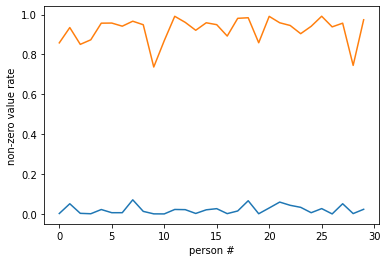

In [318]:
plt.plot(checked_NMF_missings[:30, 1])
plt.plot(checked_NMF_missings[:30, 2])
plt.ylabel('non-zero value rate')
plt.xlabel('person #')

In [331]:
test = np.array([[1,2,3, 5],[4,5,6,8]])
print(np.hsplit(test, 2))
print(np.vsplit(test, 2))

[array([[1, 2],
       [4, 5]]), array([[3, 5],
       [6, 8]])]
[array([[1, 2, 3, 5]]), array([[4, 5, 6, 8]])]


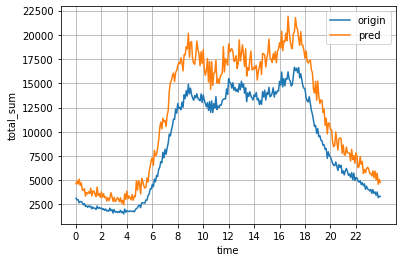

In [341]:
fig, ax = plt.subplots()
ax.plot(np.sum(np.sum(np.hsplit(obs_matrix_sum, 12), axis=1), axis=0), label='origin')
ax.plot(np.sum(np.sum(np.hsplit(WH, 12), axis=1), axis=0),label='pred')

ax.set_ylabel('total_sum')
ax.set_xticks(np.arange(0, 288, 24))
ax.set_xticklabels(np.arange(0, 24, 2))
ax.set_xlabel('time')
ax.grid()
leg = ax.legend(bbox_to_anchor=(1, 1))


In [359]:
def gettime_loc(time, num_zone, time_interval):
    time_loc = []
    for i in range(num_zone):
        time_loc.append(time+time_interval*i)
    return(time_loc)

In [362]:
test = gettime_loc(0, 12, 288)

In [396]:
test = np.ones((2,3))
np.vstack((test, np.array([2,2,2])))

array([[1., 1., 1.],
       [1., 1., 1.],
       [2., 2., 2.]])

In [425]:
def get_revised_mxbytime(input_matrix):
    for time in range(288):
        #  print(time)
        time_loc = gettime_loc(time, 12, 288)
        if time == 0:
            revised_obssum_bytime = input_matrix[:, time_loc]
        else:
            revised_obssum_bytime = np.vstack((revised_obssum_bytime, input_matrix[:, time_loc]))
    revised_obssum_bytime = np.vsplit(revised_obssum_bytime, 288)

In [421]:
revised_obssum_bytime = get_revised_mxbytime(obs_matrix_sum)

In [426]:
revised_predsum_bytime = get_revised_mxbytime(WH)

In [408]:
gettime_loc(1, 12, 288)

[1, 289, 577, 865, 1153, 1441, 1729, 2017, 2305, 2593, 2881, 3169]

In [209]:
model_results_mx = model_results.to_numpy()
k_interval = 25
a_interval = 5

def get_index(start_index, index_range, index_interval):
    para_index = []
    for i in range(len(index_range)):
        para_index.append(start_index+i*index_interval)
    return(para_index)



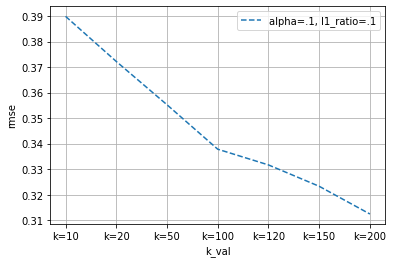

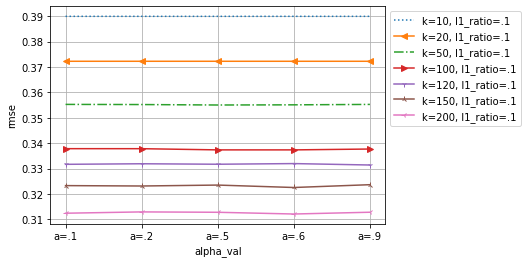

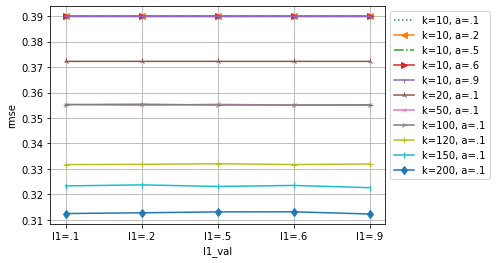

In [343]:
#sensitive test
#plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
#plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
fig, ax = plt.subplots()
ax.plot(model_results_mx[get_index(0, k_range, k_interval), 3], '--', label='alpha=.1, l1_ratio=.1')
#ax.plot(model_results_mx[get_index(1, k_range, k_interval), 3], '-', label='alpha=.1, l1_ratio=.2')
#ax.plot(model_results_mx[get_index(2, k_range, k_interval), 3], '-.', label='alpha=.1, l1_ratio=.5')
#ax.plot(model_results_mx[get_index(3, k_range, k_interval), 3], ':', label='alpha=.1, l1_ratio=.')
#ax.plot(model_results_mx[get_index(4, k_range, k_interval), 3], '.', label='alpha=.1, l1_ratio=.1')

ax.set_ylabel('rmse')
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(['k=10', 'k=20', 'k=50', 'k=100', 'k=120', 'k=150', 'k=200'])
ax.set_xlabel('k_val')
ax.grid()
leg = ax.legend(bbox_to_anchor=(1, 1))


fig, ax = plt.subplots()
ax.plot(model_results_mx[get_index(0, a, a_interval), 3], ':', label='k=10, l1_ratio=.1')
ax.plot(model_results_mx[get_index(25, a, a_interval), 3], '-<', label='k=20, l1_ratio=.1')
ax.plot(model_results_mx[get_index(50, a, a_interval), 3], '-.', label='k=50, l1_ratio=.1')
ax.plot(model_results_mx[get_index(75, a, a_interval), 3], '->', label='k=100, l1_ratio=.1')
ax.plot(model_results_mx[get_index(100, a, a_interval), 3], '-1', label='k=120, l1_ratio=.1')
ax.plot(model_results_mx[get_index(125, a, a_interval), 3], '-2', label='k=150, l1_ratio=.1')
ax.plot(model_results_mx[get_index(150, a, a_interval), 3], '-3', label='k=200, l1_ratio=.1')

ax.set_ylabel('rmse')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['a=.1', 'a=.2', 'a=.5', 'a=.6', 'a=.9'])
ax.set_xlabel('alpha_val')
ax.grid()
leg = ax.legend(bbox_to_anchor=(1, 1))

fig, ax = plt.subplots()
ax.plot(model_results_mx[get_index(0, a, 1), 3], ':', label='k=10, a=.1')
ax.plot(model_results_mx[get_index(5, a, 1), 3], '-<', label='k=10, a=.2')
ax.plot(model_results_mx[get_index(10, a, 1), 3], '-.', label='k=10, a=.5')
ax.plot(model_results_mx[get_index(15, a, 1), 3], '->', label='k=10, a=.6')
ax.plot(model_results_mx[get_index(20, a, 1), 3], '-1', label='k=10, a=.9')
ax.plot(model_results_mx[get_index(25, a, 1), 3], '-2', label='k=20, a=.1')
ax.plot(model_results_mx[get_index(50, a, 1), 3], '-3', label='k=50, a=.1')
ax.plot(model_results_mx[get_index(70, a, 1), 3], '-4', label='k=100, a=.1')
ax.plot(model_results_mx[get_index(100, a, 1), 3], '-+', label='k=120, a=.1')
ax.plot(model_results_mx[get_index(125, a, 1), 3], '-|', label='k=150, a=.1')
ax.plot(model_results_mx[get_index(150, a, 1), 3], '-d', label='k=200, a=.1')

ax.set_ylabel('rmse')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['l1=.1', 'l1=.2', 'l1=.5', 'l1=.6', 'l1=.9'])
ax.set_xlabel('l1_val')
ax.grid()
leg = ax.legend(bbox_to_anchor=(1, 1))

[1305 1317 1322 1337 1349 1357 1379 1487 1691 1703 2071]
[ 9  9  2  5  5  1 11 11 11 11  7]
[53033008300, 53033008300, 53033007300, 53033008001, 53033008001, 53033007200, 53033008500, 53033008500, 53033008500, 53033008500, 53033008100]
[ 9  9  9  9  9  9  9 10 11 11 14]
[ 0  5 10 15 20 25 30 15 40 45 20]


array([ 4.,  5., 16.,  2., 13., 21.,  2.,  2.,  2.,  2.,  1.])

In [151]:
sim_test = pd.read_csv('output.csv', index_col=0)
sim_test
np.unique(sim_test['personid'])

array(['1000432_1', '100231_1', '1004340_5', '1004689_1', '1005231_1',
       '1006343_2', '1006906_2', '1007495_2', '1010274_1', '1010381_1',
       '1011210_12', '1011887_1', '1011974_1', '1011994_1', '1012026_1',
       '1012495_1', '1012926_1', '1014035_1', '1014944_1', '1015185_2',
       '101616_2', '1017651_5', '101891_1', '1019600_1', '101969_1',
       '101971_1', '101996_1', '1020024_1', '102022_1', '102036_1',
       '1020375_1', '1020479_1', '1020527_1', '1020897_2', '102100_1',
       '102125_1', '1021503_1', '102153_2', '1021834_1', '102184_1',
       '102185_2', '1021996_1', '1022258_1', '1022723_2', '1022821_1',
       '102290_1', '102295_1', '102313_3', '1023182_1', '102334_3',
       '1023352_2', '102343_3', '1023454_1', '1023465_2', '102347_1',
       '1023518_1', '102370_3', '102372_2', '1023768_2', '102385_1',
       '102398_1', '102403_3', '102439_3', '102441_1', '102510_1',
       '1025671_1', '1026477_1', '1027267_2', '1027489_3', '102748_2',
       '102760_1', 

array([53033007100, 53033007200, 53033007300, 53033007401, 53033007402,
       53033008001, 53033008002, 53033008100, 53033008200, 53033008300,
       53033008400, 53033008500], dtype=int64)

In [ ]:
#check non_zero ratios
obs_matrix_sum

In [391]:
def get_hourly_obs(matrix):
    return(np.sum(np.sum(np.sum(matrix, axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))

def get_obsids(matrix, num_census):
    m = matrix.copy()
    m = np.hsplit(m, num_census)
    
    for i in range(num_census):
        if i == 0:
            sum_m = cal_census_obsby30min(m[i])
        else:
            sum_m = sum_m + cal_census_obsby30min(m[i])
            
    sum_m[sum_m >= 1] = 1
    sum_m[sum_m <= 0.1] = 0
    return(np.sum(sum_m, axis=0))

def cal_census_obsby30min(census_m):
    census_m = np.hsplit(census_m, 48)
    census_m = np.sum(census_m, axis=2)
    return(census_m.T)


#get total number of obs by 30min in a day
def get_hourly_obs(matrix):
    return(np.sum(np.sum(np.sum(matrix, axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))


def sum_plot_hourly(test_dt, WH, density_plot=True):
    cur_dt = get_hourly_obs(test_dt)
    avg_cur_dt = cur_dt/np.sum(test_dt)
    
    est1 = get_hourly_obs(WH)
    avg_est1 = est1/np.sum(WH)
    
    #est2 = get_hourly_obs(WH_nozero)
    #avg_est2 = est2/np.sum(WH_nozero)

    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, ax = plt.subplots()
    if density_plot == True: 
        #ax.plot(avg_est1, label='Revised NMF predict')
        ax.plot(avg_est1, '--',label='NMF predict')
        #ax.plot(avg_est2, label='estimated 2')
        ax.plot(avg_cur_dt, '.-', label='Original data')
        ax.set_ylabel('Density')
    else:
        #ax.plot(est1, label='Revised NMF predict')
        ax.plot(est1, '--', label='NMF predict')
        #ax.plot(avg_est2, label='estimated 2')
        ax.plot(cur_dt, '.-', label='Original data')
        ax.set_ylabel('# of obs')
        
    ax.set_xticks(np.arange(0, 48, 4))
    ax.set_xticklabels(np.arange(0,24,2))
    ax.set_xlabel('Hour of day')
    ax.grid()
    leg = ax.legend(bbox_to_anchor=(1, 1))
    #ax.set_title('Hourly observation distribution (app-based data)')

def sumid_plot_hourly(test_dt, WH_nozero):
    cur_dt = get_obsids(test_dt, 12)
    #est1 = get_obsids(WH, 12)
    est2 = get_obsids(WH_nozero, 12)
    
    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, ax = plt.subplots()
    #ax.plot(est1, label='Revised NMF predict')
    ax.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax.plot(cur_dt, '.-', label='Original data')
    ax.set_ylabel('# of observed ids')
        
    ax.set_xticks(np.arange(0, 48, 4))
    ax.set_xticklabels(np.arange(0,24,2))
    ax.set_xlabel('Hour of day')
    ax.grid()
    leg = ax.legend(bbox_to_anchor=(1, 1))
    #ax.set_title('Hourly observation distribution (app-based data)')
    
#plot both obs and num of observed ids

def plot_obs_and_observed_ids(test_dt, WH_nozero):
    cur_dt = get_hourly_obs(test_dt)
    #est1 = get_hourly_obs(WH)
    est2 = get_hourly_obs(WH_nozero)
    
    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
    #ax1.plot(est1, label='Revised NMF predict')
    ax1.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax1.plot(cur_dt, '.-', label='Original data')
    ax1.set_ylabel('# of obs', fontsize=16)
        
    ax1.set_xticks(np.arange(0, 48, 4))
    ax1.set_xticklabels(np.arange(0,24,2))
    ax1.set_xlabel('Hour of day', fontsize=16)
    ax1.grid()
    
    cur_dt = get_obsids(test_dt, 12)
    #est1 = get_obsids(WH, 12)
    est2 = get_obsids(WH_nozero, 12)
    
    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    
    #ax2.plot(est1, label='Revised NMF predict')
    ax2.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax2.plot(cur_dt, '.-', label='Original data')
    ax2.set_ylabel('# of observed ids', fontsize=16)
        
    ax2.set_xticks(np.arange(0, 48, 4))
    ax2.set_xticklabels(np.arange(0,24,2))
    ax2.set_xlabel('Hour of day', fontsize=16)
    ax2.grid()
    leg = ax2.legend(bbox_to_anchor=(1, 1), fontsize=16)
    #fig.suptitle('Estimation results', fontsize=16)
    
#check 
def get_census_obsbyhr(matrix, geoids):
    census_matrix = np.sum(matrix, axis=0).reshape(12, 288)
    census_dict = {}
    for num_census in range(len(geoids)):
        census_dict[geoids[num_census]] = np.sum(census_matrix[num_census].reshape(48, 6), axis=1)
    return(census_dict)

def census_plot_hourly(test_dt, WH_nozero, geoids):
    cur_dt = get_census_obsbyhr(test_dt, geoids)
    #est1 = get_census_obsbyhr(WH, geoids)
    est2 = get_census_obsbyhr(WH_nozero, geoids)

    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    for i in range(len(geoids)):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
        
        cur_geo = geoids[i]
        #ax1.plot(est1[cur_geo], label='Revised NMF predict')
        ax1.plot(est2[cur_geo], label='NMF predict')
        #ax.plot(avg_est2, label='estimated 2')
        ax1.plot(cur_dt[cur_geo], '--', label='Original data')
        ax1.set_ylabel('# of obs')

        ax1.set_xticks(np.arange(0, 48, 4))
        ax1.set_xticklabels(np.arange(0,24,2))
        ax1.set_xlabel('Hour of day')
        ax1.grid()
        #leg = ax1.legend(bbox_to_anchor=(1, 1))
        
        #ax2.plot(est1[cur_geo]/np.sum(est1[cur_geo]), label='Revised NMF predict')
        ax2.plot(est2[cur_geo]/np.sum(est2[cur_geo]), label='NMF predict')
        #ax.plot(avg_est2, label='estimated 2')
        ax2.plot(cur_dt[cur_geo]/np.sum(cur_dt[cur_geo]), '--', label='Original data')
        ax2.set_ylabel('density')

        ax2.set_xticks(np.arange(0, 48, 4))
        ax2.set_xticklabels(np.arange(0,24,2))
        ax2.set_xlabel('Hour of day')
        ax2.grid()
        fig.suptitle('Census tract GEOID='+str(geoids[i]))
        leg = ax2.legend(bbox_to_anchor=(1, 1))
        #ax.set_title('Hourly observation distribution (app-based data)')
        
def revise_dataforhome(convert_m, max_loc, num_census, time_seg, shape_info, check_zero):
    row, col = convert_m.shape
    zero_obs_loc = []
    for i in range(row):
        if convert_m[i][max_loc[i]] != 0:
            convert_m[i][max_loc[i]] = 1000
        else:
            if check_zero == True:
                #first ele is user index, second ele is time index
                user_timeinfo = [i//time_seg, i%time_seg]
                zero_obs_loc.append(user_timeinfo)
    
    convert_m[convert_m < 1000] = 0
    convert_m[convert_m == 1000] = 1
    
    #print(convert_m)
    
    revised_m = np.zeros(shape_info)
    for i in range(shape_info[0]):
        revised_m[i] = convert_m[time_seg*i:time_seg*(i+1)].T.flatten()
            
    #convert_m = convert_m.reshape(shape_info)
    #print(convert_m)
    if check_zero == True:
        return(revised_m, zero_obs_loc)
    else:
        return(revised_m)

def get_max_loc(m, num_census):
    m = np.hsplit(m, num_census)
    #print(m)
    #convert matrix ids, time * census col = (7767*288) row = 12
    for i in range(num_census):
        #select the time for each census that defines home
        #22:00 - 6:00
        if i == 0:
            convert_m = m[i].flatten()
        else:
            convert_m = np.vstack((convert_m, m[i].flatten()))
    
    #print(convert_m)
    convert_m = convert_m.T
    max_loc = np.argmax(convert_m, axis=1)
    return(convert_m, max_loc)
    
def select_idsfor_home(input_matrix, num_census, time_seg, check_zero=False):
    #split the matrix
    m = input_matrix.copy()
    shape_info = m.shape
    
    convert_m, max_loc = get_max_loc(m, num_census)
    #print(convert_m.shape)
    convert_m = revise_dataforhome(convert_m, max_loc, num_census, time_seg, shape_info, check_zero)
    return(convert_m)

def assign_valtoorigin_dt(test_dt, WH, num_census, time_seg):
    cur_dt = test_dt.copy()
    est_dt = WH.copy()
    
    shape_info = cur_dt.shape
    
    convert_cur, max_cur = get_max_loc(cur_dt, num_census)
    convert_est, max_est = get_max_loc(est_dt, num_census)
    
    row, col = convert_cur.shape
    for i in range(row):
        #assign the estimated val to ids with 0 obs given time and location
        if convert_cur[i][max_cur[i]] == 0:
            convert_cur[i][max_est[i]] = convert_est[i][max_est[i]]
            
    revised_m = np.zeros(shape_info)
    for i in range(shape_info[0]):
        revised_m[i] = convert_cur[time_seg*i:time_seg*(i+1)].T.flatten()
    return(revised_m)

def plot_num_idsinhome_census(test_dt,  WH_nozero, ct_pop, geoids, time_seg):    
    census_num = len(geoids)
    cur_dt = get_census_home(select_idsfor_home(test_dt, census_num, time_seg), census_num)
    #est1 = get_census_home(select_idsfor_home(WH, census_num, time_seg), census_num)
    est2 = get_census_home(select_idsfor_home(WH_nozero, census_num, time_seg), census_num)
    
    #x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, ax = plt.subplots()
    #ax.plot(est1, label='Revised NMF predict')
    ax.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax.plot(cur_dt, '.-', label='Original data')
    
    ax.plot(ct_pop, label='Census tract population')
    ax.set_ylabel('# of observed ids between 22:00-6:00', fontsize=12)    
    
    geo_label = ['']
    geo_label.extend(geoids)
    ax.set_xticks(np.arange(0, 13, 1))
    ax.set_xticklabels(geo_label, rotation=315)
    ax.set_xlabel('Census tract ID', fontsize=12)
    ax.grid()
    leg = ax.legend(bbox_to_anchor=(1, 1), fontsize=12)
    #ax.set_title('Hourly observation distribution (app-based data)')
    '''
    print('pop', scipy.stats.kstest(cur_dt, ct_pop))
    print('est1', scipy.stats.kstest(est1, ct_pop))
    print('est2', scipy.stats.kstest(est2, ct_pop))
    print('pop', scipy.stats.wilcoxon(cur_dt, ct_pop))
    print('est1', scipy.stats.wilcoxon(est1, ct_pop))
    print('est2', scipy.stats.wilcoxon(est2, ct_pop)) 
    print('est1 vs dt', scipy.stats.kstest(est1, cur_dt))
    print('est2 vs dt', scipy.stats.kstest(est2, cur_dt))
    print('est1 vs est2', scipy.stats.kstest(est1, est2))
    print('est1 vs dt', scipy.stats.wilcoxon(est1, cur_dt))
    print('est2 vs dt', scipy.stats.wilcoxon(est2, cur_dt))
    print('est1 vs est2', scipy.stats.wilcoxon(est1, est2))''' 
    
def get_census_home(input_matrix, num_census):
    #split the matrix
    m = input_matrix.copy()
    m = np.hsplit(m, 12)
    
    num_obs_census = []
    for i in range(num_census):
        #select the time for each census that defines home
        #22:00 - 6:00
        census_m = m[i]
        census_m = np.hstack((census_m[:, :73], census_m[:, 264:288]))
        census_m = np.sum(census_m, axis=1)
        census_m[census_m>=0.5] = 1
        #census_m[census_m<0.5] = 0
        
        num_obs_census.append(np.sum(census_m))
    return(num_obs_census)  

def check_obs_freq(input_matrix, num_census):
    #split the matrix
    m = input_matrix.copy()
    m = np.hsplit(m, 12)
    
    freq_obs_census = []
    for i in range(num_census):
        #select the time for each census that defines home
        #22:00 - 6:00
        census_m = m[i]
        census_m = np.hstack((census_m[:, :73], census_m[:, 264:288]))
        census_m[census_m>=0.1] = 1
        row, col = census_m.shape
        
        freq_m = (np.sum(census_m, axis=1)/col).T
        freq_obs_census.append(freq_m)
        #census_m[census_m<0.05] = 0    
    return(freq_obs_census)  

def get_obs_mean(input_matrix, num_census):
    freq_m = np.array(check_obs_freq(input_matrix, num_census)).T
    return(np.mean(freq_m, axis=0))

def plot_num_idsinhomehr(test_dt, WH_nozero, ct_pop, geoids, freq_index = False):
    num_census = len(geoids)
    if freq_index == True:
        cur_dt = get_obs_mean(test_dt, num_census)
        #est1 = get_obs_mean(WH, num_census)
        est2 = get_obs_mean(WH_nozero, num_census)
    else:
        cur_dt = get_census_home(test_dt, num_census)
        #est1 = get_census_home(WH, num_census)
        est2 = get_census_home(WH_nozero, num_census)
    
    #x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, ax = plt.subplots()
    #ax.plot(est1, label='Revised NMF predict')
    ax.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax.plot(cur_dt, '.-', label='Original data')
    if freq_index == False:
        ax.plot(ct_pop/4, label='Census tract population (scaled)')
        ax.set_ylabel('# of observed ids between 22:00-6:00')
    else:
        ax.set_ylabel('# of observed ids frequency between 22:00-6:00')
    
    geo_label = ['']
    geo_label.extend(geoids)
    ax.set_xticks(np.arange(0, 13, 1))
    ax.set_xticklabels(geo_label, rotation=315)
    ax.set_xlabel('Census tract ID')
    ax.grid()
    leg = ax.legend(bbox_to_anchor=(1, 1))
    #ax.set_title('Hourly observation distribution (app-based data)')
    '''
    if freq_index == False:
        print('pop', scipy.stats.kstest(cur_dt, ct_pop))
        print('est1', scipy.stats.kstest(est1, ct_pop))
        print('est2', scipy.stats.kstest(est2, ct_pop))
        print('est1 vs dt', scipy.stats.kstest(est1, cur_dt))
        print('est2 vs dt', scipy.stats.kstest(est2, cur_dt))
        print('est1 vs est2', scipy.stats.kstest(est1, est2))
        
        print('pop', scipy.stats.wilcoxon(cur_dt, ct_pop))
        print('est1', scipy.stats.wilcoxon(est1, ct_pop))
        print('est2', scipy.stats.wilcoxon(est2, ct_pop)) 
        print('est1 vs dt', scipy.stats.wilcoxon(est1, cur_dt))
        print('est2 vs dt', scipy.stats.wilcoxon(est2, cur_dt))
        print('est1 vs est2', scipy.stats.wilcoxon(est1, est2))
        
        print('pop', scipy.stats.mannwhitneyu(cur_dt, ct_pop))
        print('est1', scipy.stats.mannwhitneyu(est1, ct_pop))
        print('est2', scipy.stats.mannwhitneyu(est2, ct_pop))
        print('est1 vs dt', scipy.stats.mannwhitneyu(est1, cur_dt))
        print('est2 vs dt', scipy.stats.mannwhitneyu(est2, cur_dt))
        print('est1 vs est2', scipy.stats.mannwhitneyu(est1, est2))        

    else:
        print('est1 vs dt', scipy.stats.kstest(est1, cur_dt))
        print('est2 vs dt', scipy.stats.kstest(est2, cur_dt))
        print('est1 vs est2', scipy.stats.kstest(est1, est2))
        print('est1 vs dt', scipy.stats.wilcoxon(est1, cur_dt))
        print('est2 vs dt', scipy.stats.wilcoxon(est2, cur_dt))
        print('est1 vs est2', scipy.stats.wilcoxon(est1, est2))'''

def plot_obs_and_observed_ids(test_dt, WH):
    cur_dt = get_hourly_obs(test_dt)
    est1 = get_hourly_obs(WH)
    #est2 = get_hourly_obs(WH_nozero)
    
    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
    ##ax1.plot(est1, label='Revised NMF predict')
    ax1.plot(est1, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax1.plot(cur_dt, '.-', label='Original data')
    ax1.set_ylabel('# of obs', fontsize=16)
        
    ax1.set_xticks(np.arange(0, 48, 4))
    ax1.set_xticklabels(np.arange(0,24,2))
    ax1.set_xlabel('Hour of day', fontsize=16)
    ax1.grid()
    
    cur_dt = get_obsids(test_dt, 12)
    est1 = get_obsids(WH, 12)
    #est2 = get_obsids(WH_nozero, 12)
    
    x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    
    #ax2.plot(est1, label='Revised NMF predict')
    ax2.plot(est1, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax2.plot(cur_dt, '.-', label='Original data')
    ax2.set_ylabel('# of observed ids', fontsize=16)
        
    ax2.set_xticks(np.arange(0, 48, 4))
    ax2.set_xticklabels(np.arange(0,24,2))
    ax2.set_xlabel('Hour of day', fontsize=16)
    ax2.grid()
    leg = ax2.legend(bbox_to_anchor=(1, 1), fontsize=16)
    #fig.suptitle('Estimation results', fontsize=16)

In [395]:
geoids = np.unique(obs_Seattle['GEOID10'])

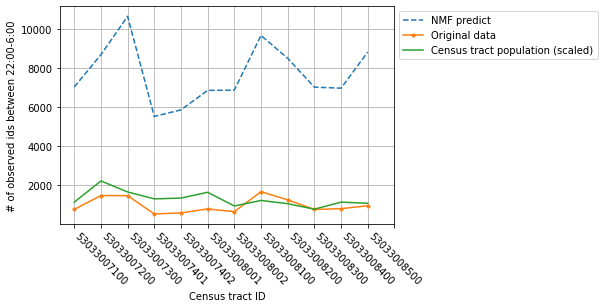

In [397]:
plot_num_idsinhomehr(obs_matrix_sum_del, WH, ct_pop, geoids)

In [400]:
def plot_num_idsinhome_census(test_dt, WH_nozero, ct_pop, geoids, time_seg, percentage_index=False):    
    census_num = len(geoids)
    cur_dt = get_census_home(select_idsfor_home(test_dt, census_num, time_seg), census_num)
    #est1 = get_census_home(select_idsfor_home(WH, census_num, time_seg), census_num)
    est2 = get_census_home(select_idsfor_home(WH_nozero, census_num, time_seg), census_num)
    
    if percentage_index == True:
        cur_dt = cur_dt/np.sum(cur_dt)
        #est1 = est1/np.sum(est1)
        est2 = est2/np.sum(est2)
        ct_pop = ct_pop/np.sum(ct_pop)
    
    #x = np.arange(0, 48, 0.5)
    #plt.plot(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0))
    #plt.plot(np.sum(np.sum(np.sum(test_matrice_reverse[:, 1:], axis=0).reshape(12, 288), axis=0).reshape(48, 6), axis=1))
    fig, ax = plt.subplots()
    #ax.plot(est1, label='Revised NMF predict')
    ax.plot(est2, '--', label='NMF predict')
    #ax.plot(avg_est2, label='estimated 2')
    ax.plot(cur_dt, '.-', label='Original data')
    
    ax.plot(ct_pop, label='Census tract population')
    if percentage_index == True:
        ax.set_ylabel('% of observed ids between 22:00-6:00', fontsize=12)    
    else:
        ax.set_ylabel('# of observed ids between 22:00-6:00', fontsize=12)    
    
    geo_label = ['']
    geo_label.extend(geoids)
    ax.set_xticks(np.arange(0, 13, 1))
    ax.set_xticklabels(geo_label, rotation=315)
    ax.set_xlabel('Census tract ID', fontsize=12)
    ax.grid()
    leg = ax.legend(bbox_to_anchor=(1, 1), fontsize=12)
    #ax.set_title('Hourly observation distribution (app-based data)')
    
    print('pop', scipy.stats.kstest(cur_dt, ct_pop))
    #print('est1', scipy.stats.kstest(est1, ct_pop))
    print('est2', scipy.stats.kstest(est2, ct_pop))
    #print('est1 vs dt', scipy.stats.kstest(est1, cur_dt))
    print('est2 vs dt', scipy.stats.kstest(est2, cur_dt))
    #print('est1 vs est2', scipy.stats.kstest(est1, est2))
    
    print('pop', scipy.stats.ks_2samp(cur_dt, ct_pop))
    #print('est1', scipy.stats.ks_2samp(est1, ct_pop))
    print('est2', scipy.stats.ks_2samp(est2, ct_pop))
    #print('est1 vs dt', scipy.stats.ks_2samp(est1, cur_dt))
    print('est2 vs dt', scipy.stats.ks_2samp(est2, cur_dt))
    #print('est1 vs est2', scipy.stats.ks_2samp(est1, est2))
    
    print('pop', scipy.stats.wilcoxon(cur_dt, ct_pop))
    #print('est1', scipy.stats.wilcoxon(est1, ct_pop))
    print('est2', scipy.stats.wilcoxon(est2, ct_pop)) 
    #print('est1 vs dt', scipy.stats.wilcoxon(est1, cur_dt))
    print('est2 vs dt', scipy.stats.wilcoxon(est2, cur_dt))
    #print('est1 vs est2', scipy.stats.wilcoxon(est1, est2))
    
    print('pop', scipy.stats.mannwhitneyu(cur_dt, ct_pop))
    #print('est1', scipy.stats.mannwhitneyu(est1, ct_pop))
    print('est2', scipy.stats.mannwhitneyu(est2, ct_pop))
    #print('est1 vs dt', scipy.stats.mannwhitneyu(est1, cur_dt))
    print('est2 vs dt', scipy.stats.mannwhitneyu(est2, cur_dt))
    #print('est1 vs est2', scipy.stats.mannwhitneyu(est1, est2))

pop KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est2 KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est2 vs dt KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
pop KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est2 KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est2 vs dt KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
pop WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est2 WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est2 vs dt WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
pop MannwhitneyuResult(statistic=0.0, pvalue=3.6584553538971e-05)
est2 MannwhitneyuResult(statistic=144.0, pvalue=3.6584553538971e-05)
est2 vs dt MannwhitneyuResult(statistic=144.0, pvalue=3.6584553538971e-05)


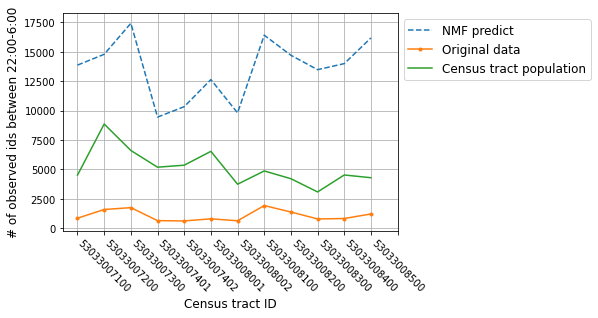

In [401]:
plot_num_idsinhome_census(obs_matrix_sum, WH,  ct_pop, geoids, 288)

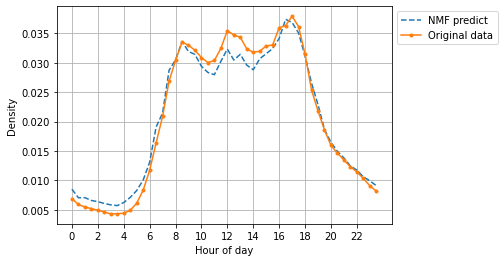

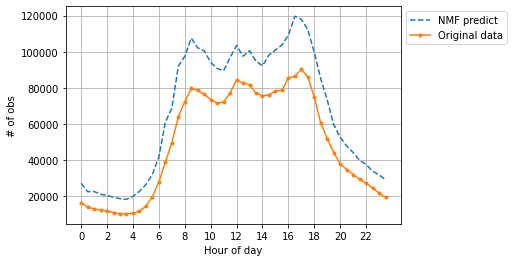

In [405]:
sum_plot_hourly(obs_matrix_sum_del, WH)

sum_plot_hourly(obs_matrix_sum_del, WH, density_plot=False)

pop KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est2 KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est2 vs dt KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
pop KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est2 KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
est2 vs dt KstestResult(statistic=1.0, pvalue=7.396023010506791e-07)
pop WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est2 WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
est2 vs dt WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
pop MannwhitneyuResult(statistic=0.0, pvalue=3.6584553538971e-05)
est2 MannwhitneyuResult(statistic=144.0, pvalue=3.6584553538971e-05)
est2 vs dt MannwhitneyuResult(statistic=144.0, pvalue=3.6584553538971e-05)


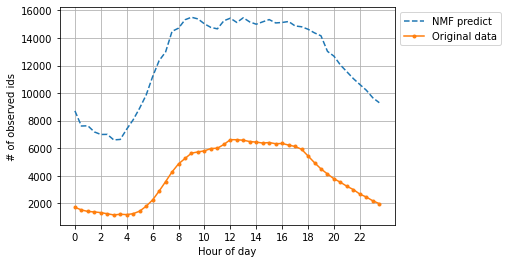

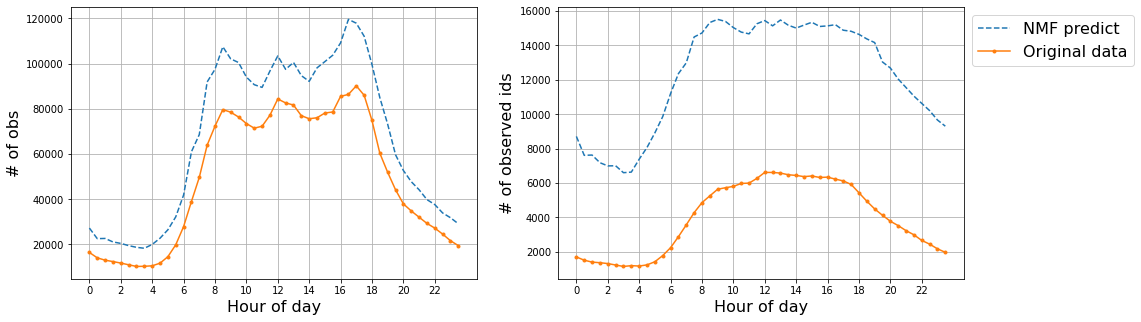

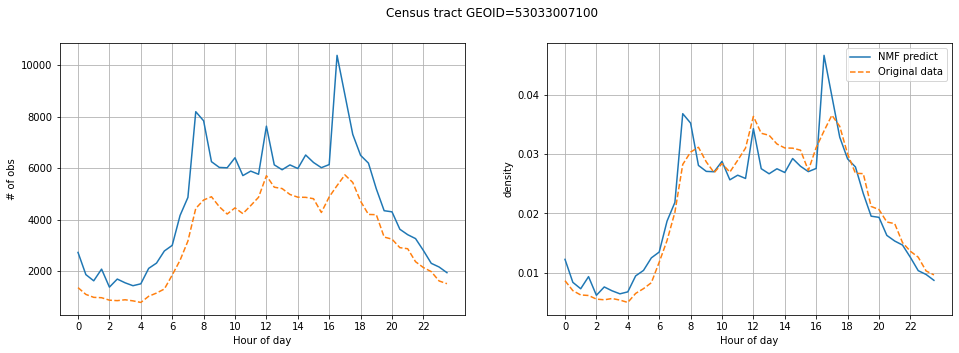

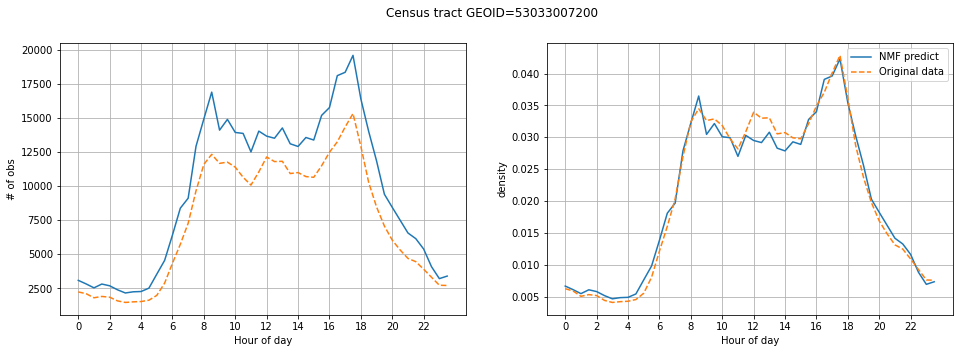

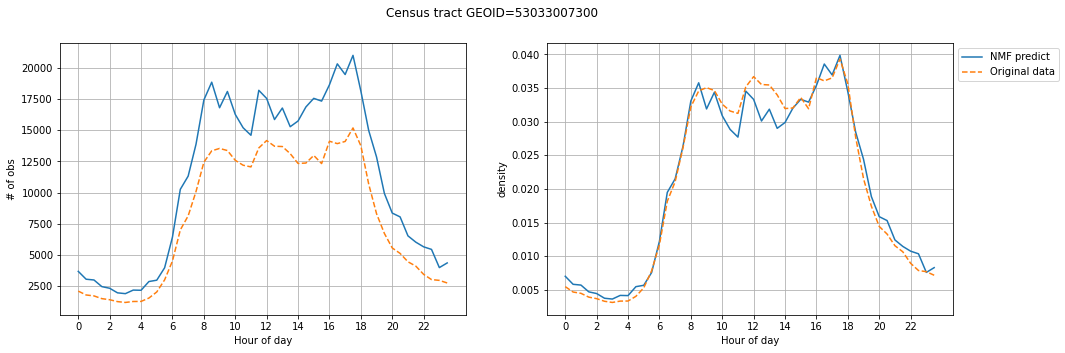

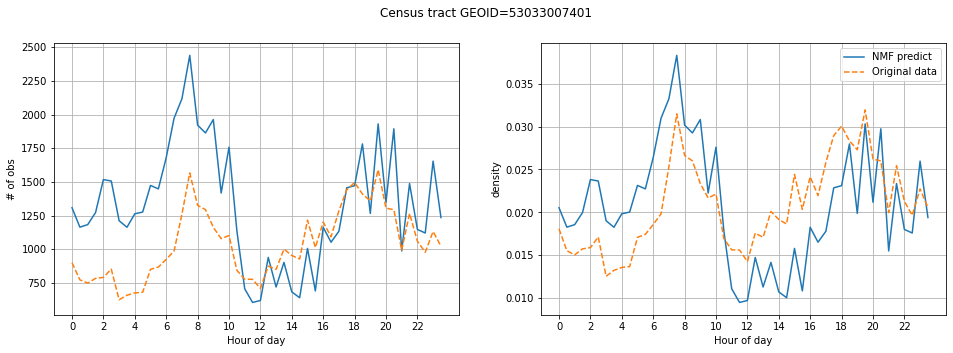

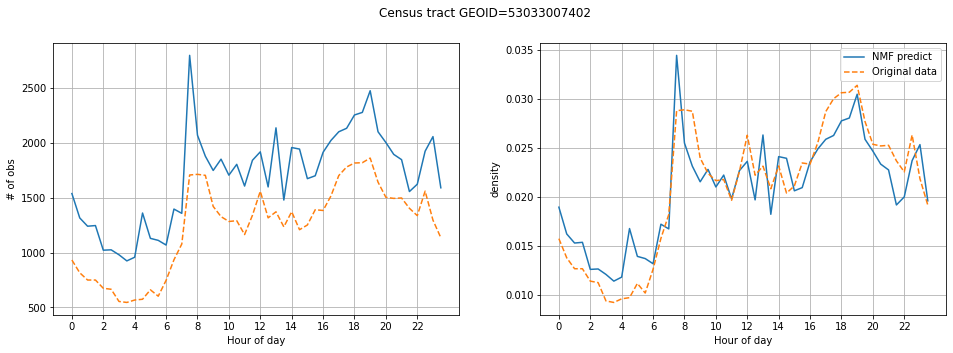

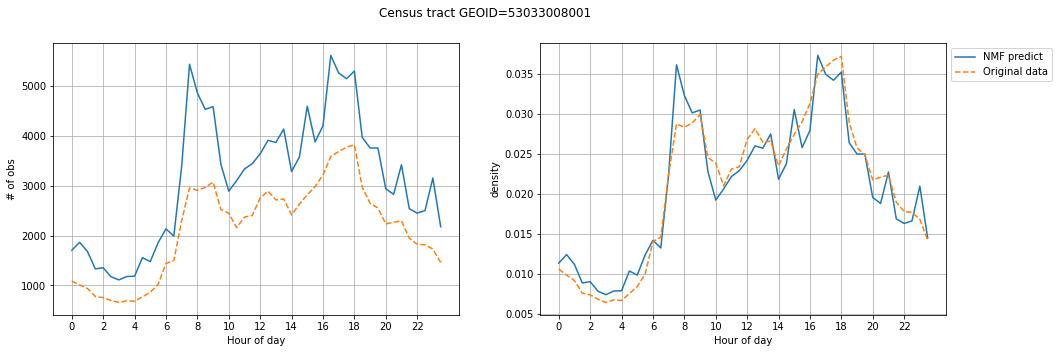

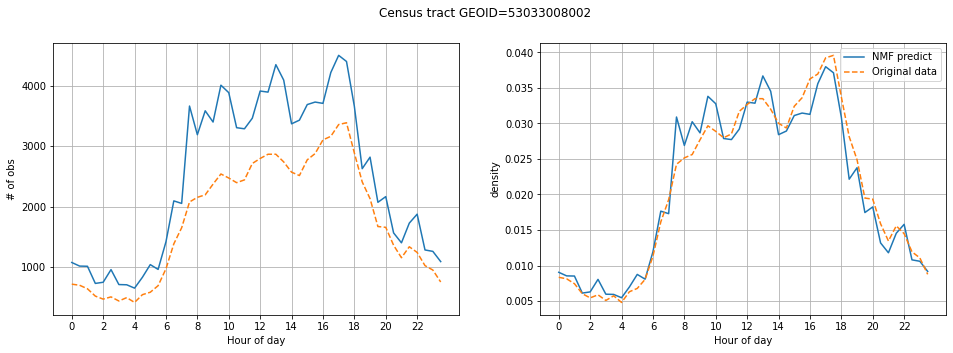

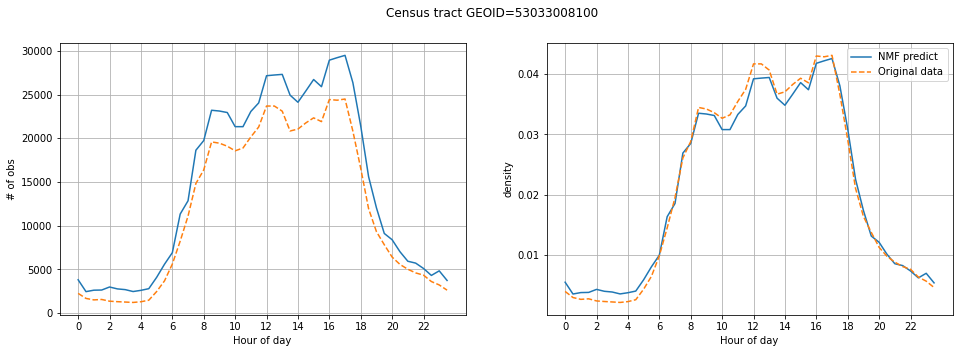

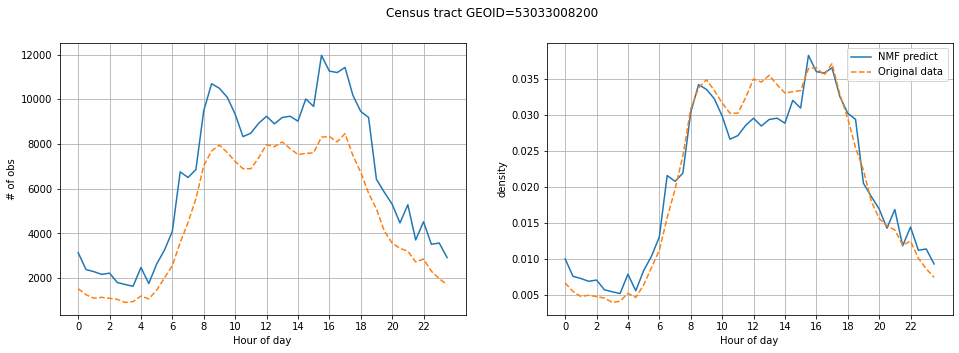

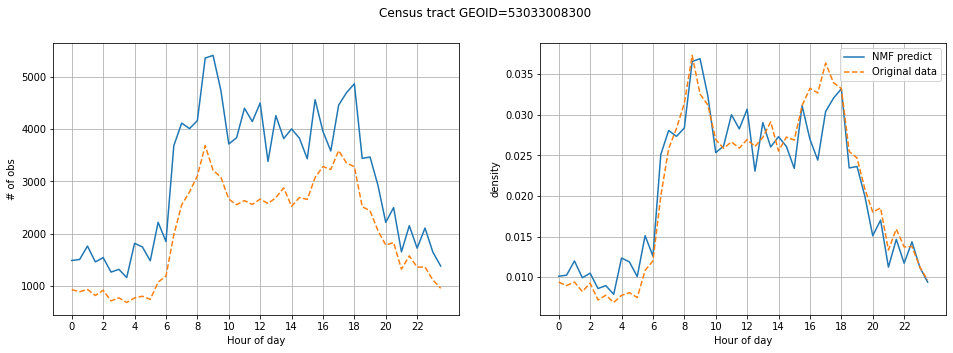

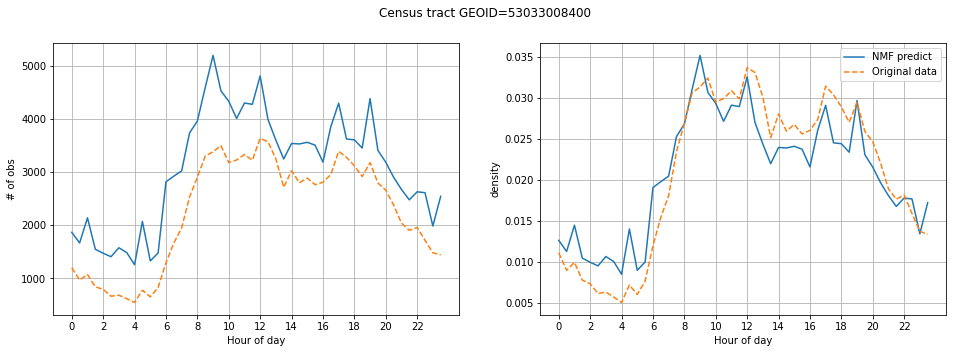

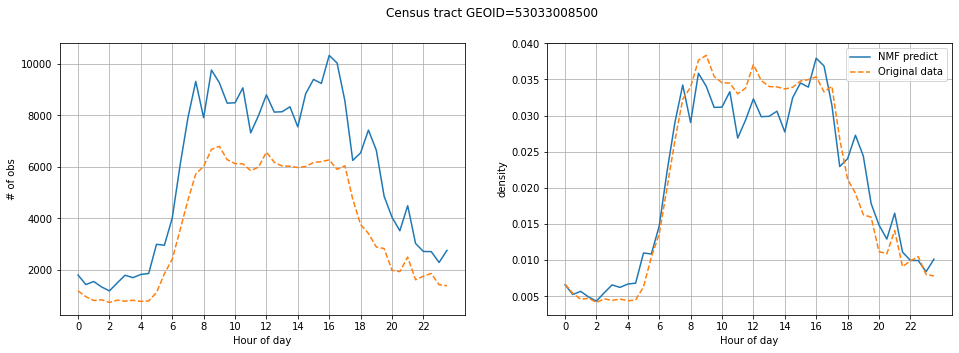

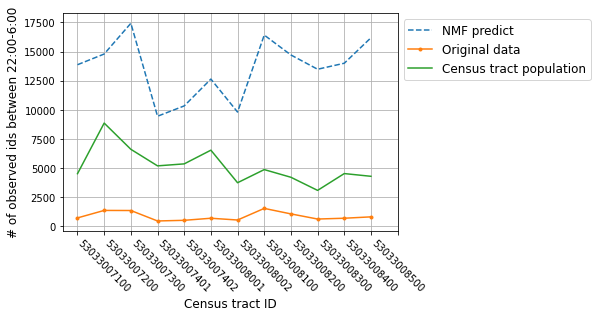

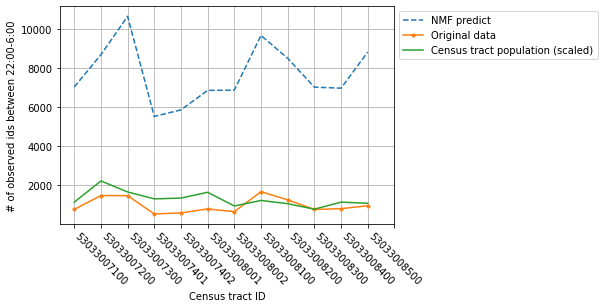

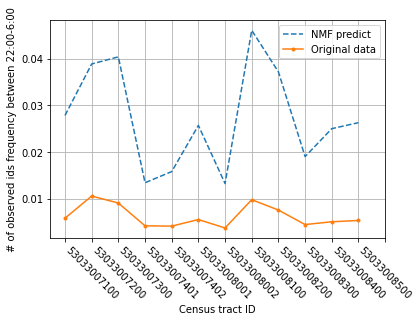

In [406]:
#plot number of ods
sumid_plot_hourly(obs_matrix_sum_del, WH)

#num obs vs num ids
plot_obs_and_observed_ids(obs_matrix_sum_del, WH) #(combine of plot ods and density)

#check hourly obs by census
census_plot_hourly(obs_matrix_sum_del, WH, geoids)

#check num ids by census
plot_num_idsinhome_census(obs_matrix_sum_del, WH, ct_pop, geoids, 288)

#check frequency (#not considering the exclusive info from the users in the estimation results)
plot_num_idsinhomehr(obs_matrix_sum_del, WH, ct_pop, geoids)
plot_num_idsinhomehr(obs_matrix_sum_del, WH, ct_pop, geoids, True)

In [116]:
#read latlon id with home identified
def read_data(filepath, homepath):
    #read ids with home identified
    id_withhome = pd.read_csv(homepath, header=None, sep='\t')
    id_withhome.columns = ['newid','lat','lon']
    id_latlon = pd.read_csv(filepath, header=0, sep=',')
    #get ids
    homeids = list(np.unique(id_withhome.newid))
    id_latlon = id_latlon[id_latlon.newid.isin(homeids)]
    return(id_latlon)
    print(id_latlon.head(3))
    
def convert_to_shp(filepath, homepath):
    points = read_data(filepath, homepath)
    geo_points = gpd.GeoDataFrame(points,
                                 geometry=gpd.points_from_xy(points['lon'],\
                                                           points['lat']),\
                                crs={'init': 'epsg:4326'})
    return(geo_points)

#make sure the default crs for zone file is espg4326
def spatial_join(zone_path, points):
    Zone = gpd.read_file(zone_path)
    Zone.crs = points.crs
    points = gpd.tools.sjoin(points, Zone, how='left')
    return(points)

#conduct a small test to make sure the spatial join works
def small_sjoin_test(zonepath, data):
    test_dt = spatial_join(zonepath, data.iloc[:15])
    geoid = np.unique(test_dt['GEOID10'])
    if 'nan' in geoid:
        print('join not successfully')
        print(geoid)
    else:
        print(geoid)
    return(test_dt)
    
#plot zone and points to make sure they are in the same projection
def plot_point_zone(zone_path, points):
    zone = gpd.read_file(zone_path)
    base = zone.plot(color='white', edgecolor='grey')
    points.plot(ax=base, marker='o', color='red', markersize=5)
    

    
#convert_data
#get total locts
def get_total_locts(obs_data):
    locts = []
    for geoid in np.unique(obs_data['GEOID10']):
        for hr in np.unique(obs_data['hr']):
            for minut in np.unique(obs_data['minut_5']):
                a = str(geoid)+'_'+str(hr)+'_'+str(minut)
                locts.append(a)
    nb_locts = len(locts)
    return(locts, nb_locts)

#assign demographic information
#percentage calculation based on smartphone demographic variety
def get_sm_per(pop_ids, num_groups):
    num_group = num_groups
    sample_ids = pd.DataFrame()
    est_ratio = []
    sample_ids['GEOID10'] = pop_ids['GEOID10']
    sample_ids['sum'] = pop_ids['sum']
    
    np.random.seed(42)
    for i in range(num_group):
        sample_ids['g'+str(i+1)] = pop_ids['g'+str(i+1)]*(np.random.normal(est_sm['mean'][i], est_sm['se'][i],1)[0])*(np.random.normal(est_sm['mean'][18], est_sm['se'][18],1)[0])
        est_ratio.append(np.random.normal(est_sm['mean'][i], est_sm['se'][i],1)[0])
    est_ratio.append(np.random.normal(est_sm['mean'][18], est_sm['se'][18],1)[0])
        
    sample_ids['per_sum'] = sample_ids[['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
                'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']].sum(axis=1)
    for i in range(num_group):
        sample_ids['g'+str(i+1)] = sample_ids['g'+str(i+1)]/sample_ids['per_sum']
        sample_ids['g'+str(i+1)] = round(sample_ids['g'+str(i+1)]*sample_ids['sum'],1)
    return(sample_ids, est_ratio)

def get_pop_per(sample_ids, num_groups):
    for i in range(num_group):
        sample_ids['g'+str(i+1)] = sample_ids['g'+str(i+1)]/sample_ids['pop']
    for i in range(num_group):
        sample_ids['g'+str(i+1)] = round(sample_ids['g'+str(i+1)]*sample_ids['sum'],1)
    return(sample_ids)

def assign_demo(sample_ids, id_data, random_seed):
    random.seed(random_seed)
    demo_labels = []
    #convert sample ids into int
    sample_ids_dict = {}
    for i in ['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
            'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']:
        sample_ids_dict[i] = []
    
    for i in range(len(sample_ids.index)):
        census_demo = sample_ids[['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
            'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']].iloc[i].to_frame()
        census_demo.columns = ['ori']
        census_demo['int'] = (census_demo['ori']).astype('int')
        census_demo['float'] = census_demo['ori']-census_demo['int']
        census_demo['group_num'] = round(census_demo['ori'],0)
        
        current_sum = census_demo['group_num'].sum()
        ct_sum = sample_ids['sum'][i]
        diff = int(current_sum-ct_sum)
        if diff < 0:
            #convert negative number to positive number
            diff = -diff
            index_num = census_demo[(census_demo['float']<=0.4)].sort_values(by=['float','int'], ascending=False).index[:diff]
            for j in index_num:
                census_demo.at[j,'group_num'] = census_demo.at[j,'group_num']+1
        elif diff > 0:
            #get list of data since -1 can cause negative number
            dt = census_demo[(census_demo['float']>=0.5)].sort_values(by=['float','int'])
            #assign an number to match the diff num
            test_num = 0
            for k in dt.index:
                if test_num < diff:
                    if  census_demo.at[k,'group_num']-1 >= 0:
                        census_demo.at[k,'group_num'] = census_demo.at[k,'group_num']-1
                        test_num = test_num+1
                    else:
                        pass
                else:
                    break
        else:
            pass
        
        if census_demo['group_num'].sum()-sample_ids['sum'][i] != 0:
            print('error!, check the code')
            print(i)
            print(census_demo)
            print(census_demo['group_num'].sum())
            print(sample_ids['sum'][i])
        
        else:
            for k in range(len(census_demo['group_num'])):
                sample_ids_dict[census_demo.index[k]].append(census_demo['group_num'][k])
                
            demo_label = []
            #print(i)
            #print(census_demo)
            for m in range(len(census_demo['group_num'])):
                demo_num = census_demo['group_num'].index[m]
                demo_label.extend(list(np.repeat(demo_num, census_demo['group_num'][m])))
            random.shuffle(demo_label)
            demo_labels.extend(demo_label)
            #convert demo label to number lebels
            num_demo_labels = []
            for labels in demo_labels:
                num_demo_labels.append(int(labels[1:]))
    id_data['demo_group'] = num_demo_labels
    
    return(id_data)


def get_demo_ratio(df, num_groups):
    num_group = num_groups
    
    demo_ratio = pd.DataFrame()
    demo_ratio['GEOID10'] = df['GEOID10']
    demo_ratio['pop'] = df['pop']
    for i in range(num_group):
        demo_ratio['g'+str(i+1)] = df['g'+str(i+1)]/df['pop']
    return(demo_ratio)

#percentage of different demo based on the smartphone pop
def get_smart_demo_ratio(df, est_ratio, num_groups):
    smart_ratio = pd.DataFrame()
    smart_ratio['GEOID10'] = df['GEOID10']
    for i in range(num_groups):
        smart_ratio['g'+str(i+1)] = df['g'+str(i+1)]*est_ratio[i]
    smart_ratio['sm_sum'] =  smart_ratio[['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
                'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']].sum(axis=1)
    for i in range(num_groups):
        smart_ratio['g'+str(i+1)] = smart_ratio['g'+str(i+1)]/smart_ratio['sm_sum']
    
    smart_ratio['ratio_sum'] =  smart_ratio[['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
                'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']].sum(axis=1)
    return(smart_ratio)

#calculate the statistical distance
def cal_stat_dist(demo_ratio, smart_ratio):
    stats_df = pd.DataFrame()
    stats_df['GEOID10'] = demo_ratio['GEOID10']
    ws_dist = []
    group_names = ['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8',\
                'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18']
    for geoid in stats_df['GEOID10']:
        ws_dist.append(wasserstein_distance(demo_ratio[group_names][demo_ratio['GEOID10']==geoid].values[0]*smart_ratio['sm_sum'][smart_ratio['GEOID10']==geoid].values[0],\
                                         smart_ratio[group_names][smart_ratio['GEOID10']==geoid].values[0]*smart_ratio['sm_sum'][smart_ratio['GEOID10']==geoid].values[0]))

    stats_df['ws_dist'] = ws_dist
    return(stats_df)

#conduct mapping 
def get_map_loc(obs_data, locts):
    newid_map = {}
    locts_map = {}
    index_num1 = 0
    index_num2 = 0
    for i in np.unique(obs_data['newid']):
        newid_map[i] = index_num1
        index_num1 = index_num1+1
    for j in locts:
        locts_map[j] = index_num2
        index_num2 = index_num2+1
    return(newid_map, locts_map)

def assign_value2matrix(obs_data, newids_map, locts_map, matrices, obs_value):
    locts = list(obs_data['spatial_temporal_id'])
    newids = list(obs_data['newid'])
    #obs_num = list(obs_data['norm_obs'])
    obs_num = list(obs_data[obs_value])
    for i in range(len(locts)):
        #matrices[locts_map[locts[i]], newids_map[newids[i]]] = obs_num[i]
        matrices[locts_map[locts[i]], newids_map[newids[i]]] = obs_num[i]
        #print(locts_map[locts[i]], newids_map[newids[i]], obs_num[i])
    return(matrices)

#split_matric
def split_1(data, ratio, tensor=False):
    train = np.zeros((len(data), len(data[0]))).tolist()
    valid = np.zeros((len(data), len(data[0]))).tolist()

    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] > 0:
                if np.random.binomial(1, ratio, 1):
                    train[i][j] = data[i][j]
                else:
                    valid[i][j] = data[i][j]

    return [train, valid]

#add demo info
def split_2(data, ratio, tensor=False):
    train = np.zeros((len(data), len(data[0]))).tolist()
    valid = np.zeros((len(data), len(data[0]))).tolist()

    for i in range(len(data)):
        for j in range(len(data[i])):
            if j < 18:
                train[i][j] = data[i][j]
                valid[i][j] = data[i][j]
            else:    
                if data[i][j] > 0:
                    if np.random.binomial(1, ratio, 1):
                        train[i][j] = data[i][j]
                    else:
                        valid[i][j] = data[i][j]

    return [train, valid]

def split_demo(data, list_index=False):
    if list_index == False:
        data_wo_demo = np.zeros((data.shape[0],(data.shape[1]-18)))
        for i in range(data.shape[0]):
            data_wo_demo[i] = data[i][18:] 
    else:
        data_wo_demo = []
        for i in range(len(data)):
            data_wo_demo.append(data[i][18:])
    return(data_wo_demo)

def get_homeloc(selected_ids):
    ids_with_home = pd.read_csv('cuebiq_home_psrc_raw.csv', \
                                header=None, sep='\t')
    ids_with_home.columns = ['newid','lat','lon']
    #conver ids into shapefile
    ids_with_home = ids_with_home[ids_with_home['GEOID10'].isin(selected_idsds)]
    ids_with_home =  gpd.GeoDataFrame(ids_with_home,\
                                      geometry=gpd.points_from_xy(ids_with_home['lon'],\
                                                                  ids_with_home['lat']),\
                                      crs={'init': 'epsg:4326'})
    ids_with_home = gpd.tools.sjoin(ids_with_home, CensusTract, how='left')
    ids_with_home = ids_with_home[['newid','lat', 'lon','GEOID10']]
    return(ids_with_home)

def c2num(x):
    return(int(x[1:]))

#check data popularity
def check_data_popularity(Seattle_df, col4obs_rates):
    len(np.unique(Seattle_df['newid']))
    #get value for each loc,t
    loc_time_popularity = Seattle_df.groupby('spatial_temporal_id')[col4obs_rates].sum().sort_values(ascending=False).reset_index()
    print('top 10 pop loc+time')
    print(loc_time_popularity.head(10))

    plt1 = plt.figure(1)
    plt.plot(loc_time_popularity[col4obs_rates].values)
    plt.title('obs_popularity_frequency')

    #check data in Seattle area
    census_t = []
    hours = []
    for i in loc_time_popularity['spatial_temporal_id'].values:
        cs_time = i.split('_')
        if cs_time[0] not in census_t:
            census_t.append(cs_time[0])
        if cs_time[1] not in hours:
            hours.append(cs_time[1])
    print('popular ct: ', census_t)
    print('popular hr: ', hours)

    #observation popularity
    Seattle_map = CensusTract[CensusTract['GEOID10'].isin(census_t)]
    a = list(Seattle_map['GEOID10'].values)
    vals = []
    ranks_val = []
    num_cts = len(census_t)
    val = num_cts
    for i in range(num_cts):
        vals.append(val)
        val -= 1

    for i in range(num_cts):
        idx = census_t.index(a[i])
        ranks_val.append(vals[idx])
    Seattle_map['pop_rank'] = ranks_val
    
    plttest = plt.figure(3)
    fig, ax = plt.subplots(1, 1)
    Seattle_map.plot(column='pop_rank', ax=ax, legend=True, cmap='OrRd')

    #temporal popularity
    plt2 = plt.figure(2)
    a = 0
    for i in hours:
        hours[a] = int(i)
        a = a+1
    rank_x = list(range(0,24))
    
    plt.scatter(rank_x,hours)
    plt.xlim(-1, 24)
    plt.ylim(-1, 24)
    plt.xlabel('Rank')
    plt.ylabel('Hour')
    plt.grid(True)
    plt.title('Popular rank by hour')

In [ ]:
path = 'G:/My Drive/2020/Bias/data-processing/'
os.chdir(path)

latlon_shape = pd.read_csv('latlon_shape.csv')

#get test data
obs_Seattle = pd.read_csv('obs_Seattle.csv', index_col=0)
Seattle_ids = list(np.unique(obs_Seattle['GEOID10']))
#convert_to_string
a = 0 
for ids in Seattle_ids:
    Seattle_ids[a] = str(ids)
    a += 1
latlon_Seattle = latlon_shape[latlon_shape['GEOID10'].isin(Seattle_ids)]
latlon_Seattle = latlon_Seattle.reset_index()
latlon_Seattle.to_csv('latlon_Seattle.csv', index=False)


Seattle_ct = pd.read_csv('Seattle_ct.csv')
latlon_Seattle = pd.read_csv('latlon_Seattle.csv')

newids = list(np.unique(latlon_Seattle['newid']))

#test_latlon = latlon_Seattle[latlon_Seattle['newid'].isin(newids[:10])]
#test_latlon.to_csv('test_latlon.csv', index=False)

locts, nb_locts = get_total_locts(obs_Seattle)
nb_ids = len(np.unique(obs_Seattle['newid']))
#obs_Seattle.head(3)


#through checking we found that the demographic data is based on ACS 2017 survey
#thus it matches the data collected from cuebiq
demo_ct = pd.read_csv('data_stage1_v1.csv', header=0)
demo_ct.head()
est_sm =pd.read_csv('../model/poi_res_v32.csv', header=0)

est_sm.columns = ['prob','mean','se','sd','10%','90%','n_eff','Rhat']
demo_ct = demo_ct[['pop', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7',\
       'g8', 'g9', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17',\
       'g18','home_ratio','GEOID10','Count_']]

CensusTract = gpd.read_file('spatial_check/ct2010.shp')
demo_reg_df = pd.read_csv('demo_reg_df.csv')

#obs_Seattle_Bellevue.head(3)
ids_with_home = pd.read_csv('cuebiq_home_psrc_raw.csv', \
                                header=None, sep='\t')
ids_with_home.columns = ['newid','lat','lon']
#conver ids into shapefile
ids_with_home =  gpd.GeoDataFrame(ids_with_home,\
                                  geometry=gpd.points_from_xy(ids_with_home['lon'],\
                                                              ids_with_home['lat']),\
                                  crs={'init': 'epsg:4326'})
ids_with_home = gpd.tools.sjoin(ids_with_home, CensusTract, how='left')
ids_with_home = ids_with_home[['newid','lat', 'lon','GEOID10']]


#current_ids['demo_group'] = current_ids['demo_group'].apply(c2num)
#ids = np.unique(obs_Seattle_Bellevue['newid'])
#ids_with_home_bs = get_homeloc(ids)

#get the sample ratio
#per = group_pop/pop*.81*est_per
#resclae it so that sum_per=1
pop_ids = ids_with_home.groupby(['GEOID10']).size().to_frame()
pop_ids.reset_index(inplace=True)
pop_ids.columns = ['GEOID10','sum']

demo_geo = demo_ct[demo_ct['GEOID10'].isin(pop_ids['GEOID10'])]
demo_geo['GEOID10'] = demo_geo['GEOID10'].astype(str)
pop_ids = pop_ids.merge(demo_geo, on=["GEOID10", "GEOID10"])
pop_ids = pop_ids.sort_values(['GEOID10'])


sample_ids, est_ratio = get_sm_per(pop_ids, 18)
ids_with_home = assign_demo(sample_ids, ids_with_home, 42)


sample_ids, est_ratios = get_sm_per(pop_ids, 18)

demo_ratio_Seattle = get_demo_ratio(pop_ids[pop_ids['GEOID10'].isin(np.unique(obs_Seattle['GEOID10']))], 18)
smart_ratio_Seattle = get_smart_demo_ratio(pop_ids[pop_ids['GEOID10'].isin(np.unique(obs_Seattle['GEOID10']))], \
                                           est_ratios, 18)
ws_dist_test = cal_stat_dist(demo_ratio_Seattle, smart_ratio_Seattle)

newids_map, locts_map = get_map_loc(obs_Seattle, locts) 


test_matrice = np.zeros((nb_locts, nb_ids))
test_matrice_scaled = np.zeros((nb_locts, nb_ids))
test_matrice_scaled = assign_value2matrix(obs_Seattle, \
                    newids_map, locts_map, test_matrice_scaled, 'norm_obs_5')
test_matrice = assign_value2matrix(obs_Seattle, \
                    newids_map, locts_map, test_matrice, 'obs')

print('# of census tracts:', len(np.unique(obs_Seattle['GEOID10'])))
print('# of census newids:', len(np.unique(obs_Seattle['newid'])))

#obs_Seattle.head(3)
user_ids = np.unique(obs_Seattle['newid'])

#row: time_loc, column: ids

#row: ids, column: time_loc: Users * items
test_matrice_reverse = test_matrice.T
test_matrice_scaled_reverse = test_matrice_scaled.T

sparse_checkper_ids = []
obs_values_check = []
for i in test_matrice_reverse:
    #num ids at each ct,t
    sparse_checkper_ids.append(np.count_nonzero(i)/len(i))
    #num obs
    obs_values_check.append(np.sum(i)/len(i))
    
#summary of the number of ids
#pd.DataFrame(sparse_checkper_ids).describe()
#summary of observations
#pd.DataFrame(obs_values_check).describe()

plt.plot(sparse_checkper_ids[:100], color='red')
plt.plot(obs_values_check[:100], color='blue')
plt.title('obs vs. num ids')

#trnaslate group infomation
#user info
current_ids = ids_with_home[ids_with_home['newid'].isin(np.unique(obs_Seattle['newid']))]
#convert demo_group to number

current_ids = current_ids.set_index(current_ids['newid'])

demo_matrix = np.zeros((nb_ids, 18))
user_ids = list(newids_map.keys())
for k in range(len(newids_map.keys())):
    ids_index = user_ids[k]
    demo_matrix[k, current_ids.loc[ids_index]['demo_group']-1] = 1

test_matrice_scaled_reverse_demo = np.hstack([test_matrice_scaled_reverse, demo_matrix])

current_ids = current_ids.set_index(current_ids['newid'])

demo_matrix = np.zeros((nb_ids, 18))
user_ids = list(newids_map.keys())
for k in range(len(newids_map.keys())):
    ids_index = user_ids[k]
    demo_matrix[k, current_ids.loc[ids_index]['demo_group']-1] = 1

test_matrice_scaled_reverse_demo = np.hstack([test_matrice_scaled_reverse, demo_matrix])


#add user index id
user_ids_index = np.array(list(newids_map.keys()))
user_ids_index = user_ids_index.reshape(user_ids_index.shape[0],1)

test_matrice_scaled_reverse = np.hstack([user_ids_index,test_matrice_scaled_reverse])
#data not scaled
test_matrice_reverse = np.hstack([user_ids_index,test_matrice_reverse])


train_scaled, test_scaled = train_test_split(test_matrice_scaled_reverse, \
                                   test_size=0.2, random_state=42)

#method 2, not using the train, user, splitting method
#train_demo, test_demo = train_test_split(test_matrice_scaled_reverse_demo, test_size=0.2, random_state=42)
#train1, valid1 = train_test_split(train1, test_size=0.2, random_state=42)
#train_user_loct = split(train_user_loct, 0.8)


train, test = train_test_split(test_matrice_reverse, test_size=0.2,\
                              random_state=42)

Seattle_df = pd.read_csv('Seattle_obs_1.csv')
Seattle_df.head(3)


check_data_popularity(Seattle_df, 'norm_obs_5')

In [ ]:
#get selected ct o Seattle
ct_geoids = []
for i in (user_iteminfo[0][0].split(',')):
    if i[:11] not in ct_geoids:
        ct_geoids.append(i[:11])
ct_geoids = ct_geoids[:-1]

In [10]:
latlon_shape = convert_to_shp('withobs04052017.csv','cuebiq_home_psrc_raw.csv')

C:\Users\29700\anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
latlon_shape_ct = spatial_join('spatial_check/ct2010.shp', latlon_shape)
latlon_shape_ct.head(3)

,timestamp,lat,lon,accuracy,idtype,newid,d,hr,minut,obs,...,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
0,1491403081,47.756120,-122.34830,5,1,5,5,7,38,1,...,020700,53033020700,207,Census Tract 207,G5020,S,1711193.0,0.0,+47.7561636,-122.3473227
1,1491403380,47.756010,-122.33120,5,1,5,5,7,43,1,...,020600,53033020600,206,Census Tract 206,G5020,S,1974729.0,0.0,+47.7560214,-122.3321002
2,1491403620,47.801423,-122.31353,65,1,5,5,7,47,2,...,051000,53061051000,510,Census Tract 510,G5020,S,3344887.0,275673.0,+47.7926729,-122.3232195


In [16]:
user_iteminfo = []
with open ('G:/My Drive/2021/Bias/user_tsinfo.txt', 'r') as f:
    user_iteminfo.append(f.readlines())

In [ ]:
#spatial join with ct, zone range: PSRC
#read data and check if all ids has a home id
#Notice!!! shapefile needs to be converted into the same crs
#change the project property in QGIS and save the shapefile with the project crs
latlon_shape = convert_to_shp('withobs04052017.csv','cuebiq_home_psrc_raw.csv')
#convert spatial data to PSRC censustract
#small_test = small_sjoin_test('spatial_check/ct2010.shp', latlon_shape, 'GEOID10')
#plot_point_zone('spatial_check/ct2010.shp', small_test)
#CensusTract = gpd.read_file('spatial_check/ct2010.shp')
latlon_shape_ct = spatial_join('spatial_check/ct2010.shp', latlon_shape)
#latlon_shape.head(6)

#################################################################
#spatial join with cb group, zone range: PSRC
'''paths = 'G:/My Drive/2021/Bias/census_block_data/'
input_path = paths+'blockgrp2010_crs_revised.shp'
bg = gpd.read_file(input_path)

#small_test = small_sjoin_test(input_path, latlon_shape, 'GEOID10')
#plot_point_zone(input_path, small_test)

latlon_shape_bg = spatial_join(input_path, latlon_shape)

###################################################################
#spatial join with the Seattle land use data, Zone range: downtown Seattle
#Seattle test data
zone_path = 'G:/My Drive/2021/Bias/census_block_data/'
input_zone = zone_path + 'Seattle_land_ues_w_ct.shp'

#spatial join the data with the land use
Seattle_land_use = gpd.read_file(input_zone)
Seattle_land_use.crs = latlon_shape.crs
latlon_shape_Seattle = gpd.tools.sjoin(latlon_shape, Seattle_land_use, how='inner')

latlon_shape_Seattle = gpd.read_file(paths+'land_use_join_w_cuebiq_dt.shp')
latlon_shape_Seattle.head(3)'''
####################################################################
# identify if nan exisiting in the data
    
#checknull(latlon_shape, 'spatial_check/ct2010.shp', 'null_data.csv')
#checknull(latlon_shape_bg, input_path, paths+'null_data.csv')

In [92]:
#data processing
#data plot and summary for observation (total)
def plot_obs_sum(input_data, col_values, zone_col_name):
    obs_sum = input_data.sort_values(by=[col_values], ascending=False)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(obs_sum[zone_col_name],obs_sum[col_values],'.')
    obs_sum[zone_col_name] = obs_sum[zone_col_name].apply(str)
    #plt.xticks(rotation=90)
    ax.set_xlabel(zone_col_name)
    ax.set_ylabel('total # of obsrvations')
    #not print the x axis
    #ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.show()
    print(obs_sum.describe())
    print('geoid with maximum obs:', list(obs_sum[zone_col_name][obs_sum[col_values]==obs_sum[col_values].max()])[0])
    print('geoid with minimum obs:', list(obs_sum[zone_col_name][obs_sum[col_values]==obs_sum[col_values].min()])[0])
    
def plot_obs_sum01(zone_col_name, input_data):
    obs_sum = input_data.groupby([zone_col_name])['newid'].unique().to_frame()
    obs_sum.reset_index(inplace=True)
    obs_sum.columns = ['geoid','obs_01_per_day']
    obs_sum['obs_01_per_day']=obs_sum['obs_01_per_day'].apply(len)
    obs_sum = obs_sum.sort_values(by = ['obs_01_per_day'], ascending=False)
    obs_sum['geoid'] = obs_sum['geoid'].apply(str)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(obs_sum['geoid'],obs_sum['obs_01_per_day'],'.')
    #plt.xticks(rotation=90)
    ax.set_xlabel(zone_col_name)
    ax.set_ylabel('total # of obsrvations (based on binary var, 0-1)')
    #not print the x axis
    #ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.show()
    print(obs_sum.describe())
    #print(obs_sum.head(10))
    print('geoid with maximum obs:', list(obs_sum['geoid'][obs_sum['obs_01_per_day']==obs_sum['obs_01_per_day'].max()])[0])
    print('geoid with minimum obs:', list(obs_sum['geoid'][obs_sum['obs_01_per_day']==obs_sum['obs_01_per_day'].min()])[0])
    
#check total number of obs by hour
def get_obs_hour(input_data, return_index=False):
    obs_sum_hr = input_data.groupby(['hr','newid']).sum().groupby(['hr']).sum()[['obs']]
    obs_sum_hr.reset_index(inplace=True)
    obs_sum_hr.columns = ['hr','obs_sum_hr']
    obs_sum_hr = obs_sum_hr.sort_values(by = ['hr'])
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])   
    ax.bar(obs_sum_hr['hr'],obs_sum_hr['obs_sum_hr'])
    #plt.xticks(rotation=90)
    ax.set_xlabel('hr')
    ax.set_ylabel('total # of obsrvations')
    plt.show()
    print(obs_sum_hr['obs_sum_hr'].describe())
    print('maximum obs happens at time:', list(obs_sum_hr['hr'][obs_sum_hr['obs_sum_hr']==obs_sum_hr['obs_sum_hr'].max()])[0])
    print('minimum obs happens at time:', list(obs_sum_hr['hr'][obs_sum_hr['obs_sum_hr']==obs_sum_hr['obs_sum_hr'].min()])[0])
    if return_index == True:
        return(obs_sum_hr)
    
def get_obs_hour_01(input_data, return_index=False):
    ###########hour######################
    #check total number of identified ids by hour
    obs_sum_01_hr = input_data.groupby(['hr'])['newid'].unique().to_frame()
    obs_sum_01_hr.reset_index(inplace=True)
    obs_sum_01_hr.columns = ['hr','obs_per_hr']
    obs_sum_01_hr['obs_per_hr']=obs_sum_01_hr['obs_per_hr'].apply(len)
    obs_sum_01_hr = obs_sum_01_hr.sort_values(by = ['hr'])
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(obs_sum_01_hr['hr'],obs_sum_01_hr['obs_per_hr'])
    #plt.xticks(rotation=90)
    ax.set_xlabel('hr')
    ax.set_ylabel('total # of identified ids per hour')
    plt.show()
    print(obs_sum_01_hr['obs_per_hr'].describe())
    print('maximum obs happens at time:', list(obs_sum_01_hr['hr'][obs_sum_01_hr['obs_per_hr']==obs_sum_01_hr['obs_per_hr'].max()])[0])
    print('minimum obs happens at time:', list(obs_sum_01_hr['hr'][obs_sum_01_hr['obs_per_hr']==obs_sum_01_hr['obs_per_hr'].min()])[0])
    if return_index == True:
        return(obs_sum_01_hr)

def get_obs_total(input_data, zone_col_name, obs_01 = True, plot_index=True, return_data=True):
    #delete the nan data
    process_dt = input_data.copy()
    process_dt = process_dt[~process_dt[zone_col_name].isnull()]  
    #process_dt.to_csv('latlon_shape.csv')
    #print(process_dt.keys())
    #summary the identified observations
    #if we treat the obs as 0/1 per 5 min within a day
    if obs_01 == True:
        obs_sum_d = process_dt.groupby([zone_col_name,'newid']).size().to_frame()
        obs_sum_d = obs_sum_d.groupby([zone_col_name]).sum().sort_values(by=[zone_col_name])
        obs_sum_d.reset_index(inplace=True)
        obs_sum_d.columns = [zone_col_name,'obs_01_d']
        obs_col_name = 'obs_01_d'
        if plot_index == True:
            plot_obs_sum01(zone_col_name, input_data)
    #get actual obs within a day
    else:
        obs_sum_d = process_dt.groupby([zone_col_name,'newid']).sum()
        obs_sum_d = obs_sum_d.groupby([zone_col_name]).sum()[['obs']]
        obs_sum_d.reset_index(inplace=True)
        obs_sum_d.columns = [zone_col_name,'obs_sum_d']
        obs_col_name = 'obs_sum_d'
        if plot_index == True:
            plot_obs_sum(input_data, obs_col_name, zone_col_name) 
    if return_data == True:
        return(obs_sum_d)
       

In [73]:
#check the pattern at spatial level
#latlon_obs_01 = get_obs_total(latlon_shape_bg, 'GEOID10', obs_01 = True, plot_index=True, return_data=True)
#latlon_obs = get_obs_total(latlon_shape_bg, 'GEOID10', obs_01 = False, plot_index=True, return_data=True)

#check the pattern at temporal levl
#get_obs_hour(latlon_shape_bg, return_index=False)
#get_obs_hour_01(latlon_shape_bg)

#get_obs_total(latlon_shape_bg, 'GEOID10', obs_01 = True, plot_index=True, return_data=True)
#get_obs_total(latlon_shape_Seattle, 'ZONEID', obs_01 = True, plot_index=True, return_data=True)

In [176]:
zone_path = 'G:/My Drive/2021/Bias/census_block_data/'
input_zone = zone_path + 'Seattle_land_ues_w_ct.shp'

#spatial join the data with the land use
Seattle_land_use = gpd.read_file(input_zone)

In [182]:
Seattle_land_use.drop('geometry', axis=1).to_csv(input_path+r'Seattle_land_use.csv')

In [190]:
Seattle_land_use.columns

Index(['OBJECTID', 'ZONEID', 'ZONING', 'CONTRACT', 'ORDINANCE', 'EFFECTIVE',
       'HISTORIC', 'PEDESTRIAN', 'SHORELINE', 'OVERLAY', 'LIGHTRAIL', 'MHA',
       'IZ', 'MHA_VALUE', 'MIO_NAME', 'CLASS_DESC', 'CATEGORY_D', 'ZONELUT',
       'ZONELUT_DE', 'DETAIL_DES', 'ZONING_DES', 'BASE_ZONE', 'ZONING_PRE',
       'CONTRACT_P', 'ORDINANCE_', 'EFFECTIVE_', 'HISTORIC_P', 'PEDESTRI_1',
       'SHORELINE_', 'OVERLAY_PR', 'LIGHTRAIL_', 'PUBLIC_DES', 'CHAPTER',
       'CHAPTER_LI', 'SHAPE_Leng', 'SHAPE_Area', 'STATEFP10', 'COUNTYFP10',
       'TRACTCE10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [150]:
print('# of zones', len(np.unique(latlon_shape_Seattle['ZONEID'])))

# of zones 215


In [174]:
#transfer the data into matrice
df = latlon_shape_Seattle
def convertdf2obsmatrix(df, return_index=True, return_df=True):
    #time interval = 5 min
    to5min = lambda x: int(x/5)*5
    df['minut_5'] = df['minut'].apply(to5min)

    obs_df = df.groupby(['newid','ZONEID','hr','minut_5']).sum()[['obs']]
    obs_df.reset_index(inplace=True)

    #get a zero_matrix
    rows = len(np.unique(obs_df['newid']))
    columns = len(np.unique(obs_df['ZONEID'])) * 12* 24

    convert_matrix = np.zeros((rows, columns))
    obs_df['st_index'] = obs_df['ZONEID'].apply(str)+'_'+obs_df['hr'].apply(str)+'_'+obs_df['minut_5'].apply(str)

    row_index = {}
    index_r = 0
    for i in sorted(np.unique(obs_df['newid'])):
        row_index[i] = index_r
        index_r += 1
    
    col_index = {}
    index_r = 0
    for i in sorted(np.unique(obs_df['ZONEID'])):
        for hr in sorted(np.unique(obs_df['hr'])):
            for minut_5 in sorted(np.unique(obs_df['minut_5'])):
                col_index[str(i)+'_'+str(hr)+'_'+str(minut_5)] = index_r
                index_r += 1

    #convert_to user st matrix  
    for i in range(len(obs_df['newid'])):
        convert_matrix[row_index[obs_df['newid'][i]]][col_index[obs_df['st_index'][i]]] = obs_df['obs'][i]
    
    if return_index == True and return_df==True:
        print('Notice! return three var with row and column index, observation df')
        return(convert_matrix, [row_index, col_index], obs_df)
    elif return_index == True and return_df==False:
        print('Notice! return two var with row and column index')
        return(convert_matrix, [row_index, col_index])
    elif return_index == False and return_df==True:
        print('Notice! return two var with observation df')    
        return(convert_matrix, obs_df)
    else:
        return(convert_matrix)
    
    
def convert210matrix(df, rowcolindex, obs_df):
    convert_matrix = np.zeros((len(rowcolindex[0]), len(rowcolindex[1])))
    obs_df['01obs'] = 1
    for i in range(len(obs_df['newid'])):
        convert_matrix[row_index[obs_df['newid'][i]]][col_index[obs_df['st_index'][i]]] = obs_df['01obs'][i]
    return(convert_matrix)

def save_matrix2file(input_path, savedname, input_matrix):
    np.savetxt(input_path+savedname, input_matrix, delimiter=",")
    
def save_row_colindex(input_path, save_name, rowcolindex):
    f = open(input_path+save_name,"w")
    # write file
    f.write(str(rowcolindex))
    # close file
    f.close()

In [159]:
Seattle_land_use_obs, rowcolindex, obs_df = convertdf2obsmatrix(latlon_shape_Seattle)
Seattle_land_use_01obs = convert210matrix(latlon_shape_Seattle, rowcolindex, obs_df)
save_row_colindex(input_path, 'row_index.txt', rowcolindex[0])
save_row_colindex(input_path, 'col_index.txt', rowcolindex[1])

In [224]:
latlon_shape_Seattle.columns

Index(['timestamp', 'lat', 'lon', 'accuracy', 'idtype', 'newid', 'd', 'hr',
       'minut', 'obs', 'time', 'index_righ', 'OBJECTID', 'ZONEID', 'ZONING',
       'CONTRACT', 'ORDINANCE', 'EFFECTIVE', 'HISTORIC', 'PEDESTRIAN',
       'SHORELINE', 'OVERLAY', 'LIGHTRAIL', 'MHA', 'IZ', 'MHA_VALUE',
       'MIO_NAME', 'CLASS_DESC', 'CATEGORY_D', 'ZONELUT', 'ZONELUT_DE',
       'DETAIL_DES', 'ZONING_DES', 'BASE_ZONE', 'ZONING_PRE', 'CONTRACT_P',
       'ORDINANCE_', 'EFFECTIVE_', 'HISTORIC_P', 'PEDESTRI_1', 'SHORELINE_',
       'OVERLAY_PR', 'LIGHTRAIL_', 'PUBLIC_DES', 'CHAPTER', 'CHAPTER_LI',
       'SHAPE_Leng', 'SHAPE_Area', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10',
       'GEOID10', 'NAME10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'minut_5'],
      dtype='object')

In [227]:
latlon_shape_Seattle[['timestamp', 'lat', 'lon', 'accuracy','newid','hr','minut_5','obs','CLASS_DESC','ZONEID']].sort_values(by=['newid','hr','minut_5'])

,timestamp,lat,lon,accuracy,newid,hr,minut_5,obs,CLASS_DESC,ZONEID
0,1491399907,47.606866,-122.335453,26,32,6,45,3,Downtown,3702
17697,1491400869,47.612296,-122.338055,21,32,7,0,1,Downtown,3685
17698,1491401389,47.612283,-122.337964,22,32,7,5,1,Downtown,3685
17699,1491402129,47.612377,-122.337936,22,32,7,20,1,Downtown,3685
17700,1491402457,47.612377,-122.337936,21,32,7,25,1,Downtown,3685
...,...,...,...,...,...,...,...,...,...,...
55150,1491451264,47.614661,-122.348480,21,458464,21,0,1,Downtown,3684
55151,1491452449,47.614600,-122.348402,21,458464,21,20,2,Downtown,3684
55152,1491452745,47.613095,-122.343670,23,458464,21,25,2,Downtown,3684
104933,1491453290,47.611790,-122.339933,21,458464,21,30,1,Downtown,3699


In [191]:
latlon_shape_Seattle.head(3)

,timestamp,lat,lon,accuracy,idtype,newid,d,hr,minut,obs,...,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,minut_5
0,1491399907,47.606866,-122.335453,26,0,32,5,6,45,3,...,74.02,Census Tract 74.02,G5020,S,249282,0,+47.6187608,-122.3244188,POINT (-122.33545 47.60687),45
1,1491430606,47.606283,-122.334859,25,0,32,5,15,16,2,...,74.02,Census Tract 74.02,G5020,S,249282,0,+47.6187608,-122.3244188,POINT (-122.33486 47.60628),15
2,1491428832,47.606194,-122.336229,22,0,289,5,14,47,2,...,74.02,Census Tract 74.02,G5020,S,249282,0,+47.6187608,-122.3244188,POINT (-122.33623 47.60619),45


In [208]:
print(np.unique(latlon_shape_Seattle['GEOID10']))

df = latlon_shape_Seattle.groupby(['CLASS_DESC','hr']).sum()[['obs']]
df.reset_index(inplace=True)

land_use_class = np.unique(df['CLASS_DESC'])
land_use_class
'''return
array(['Commercial/Mixed Use', 'Downtown', 'Major Institutions',
       'Manufacturing/Industrial', 'Master Planned Community',
       'Multi-Family', 'Multi-Family/Residential-Commercial',
       'Seattle Mixed'], dtype=object)'''

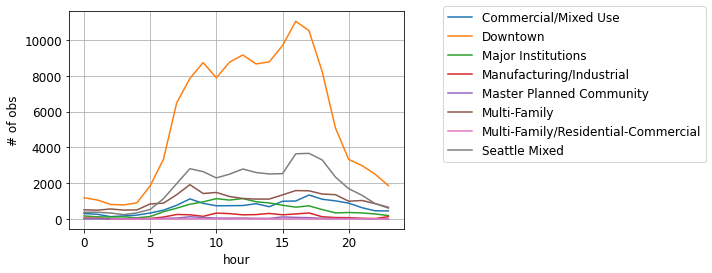

In [220]:
plt.rc('font', size=12)
plt.rc('legend', fontsize=12)

ax = plt.subplot(1,1,1)

for i in land_use_class:
    ax.plot(df['hr'][df['CLASS_DESC']==i], df['obs'][df['CLASS_DESC']==i], label=i)
    
ax.grid(True)
ax.set_ylabel("# of obs")
ax.set_xlabel('hour')

ax.legend(bbox_to_anchor=(1.1, 1.05))

In [151]:
#print(latlon_shape_Seattle.groupby(['newid','hr']).sum()[['obs']])

input_path = 'G:/My Drive/2021/Bias/census_block_data/'
save_matrix2file(input_path, 'obs_landuse.csv', Seattle_land_use_obs)
save_matrix2file(input_path, 'obs01_landuse.csv', Seattle_land_use_01obs)

#latlon_shape_Seattle.groupby(['ZONEID','hr','minut']).size()
#input_data.groupby([zone_col_name])['newid'].unique().to_frame()
#input_data.groupby(['hr','newid']).sum().groupby(['hr']).sum()[['obs']]
#input_data.groupby(['hr'])['newid'].unique().to_frame()

In [ ]:
#code not processed
#map plot
#compared with the previous figures, 
#the hourly pattern varied compared the hourly obs vs. hourly identified ids
# set a variable that will call whatever column we want to visualise on the map
variable = 'obs_sum_d'
# set the range for the choropleth
vmin, vmax = 22, 75008
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

obs_ct = CensusTract.merge(obs_sum_d, left_on='GEOID10', right_on='geoid')
#create map
obs_ct.plot(column=variable, cmap='BuGn', linewidth=0.8, \
            ax=ax, edgecolor='0.8')
#check the data
print(obs_ct['obs_sum_d'].describe())

#remove axis
ax.axis('off')
# add a title
ax.set_title('observations per census tract', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: psrc censustract 2020',xy=(0.1, .08), xycoords='figure fraction', \
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
colbar = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
colbar._A = []
# add the colorbar to the figure
cbar = fig.colorbar(colbar)
#saving our map as .png file.
#fig.savefig(‘map_export.png’, dpi=300)

# set a variable that will call whatever column we want to visualise on the map
def plot_map_based_on_var(var, data, colormap, plot_title):
    variable = var
    # set the range for the choropleth
    vmin = data[var].min()
    vmax = data[var].max()
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(10, 6))

    obs_ct = CensusTract.merge(data, left_on='GEOID10', right_on='geoid')
    #create map
    obs_ct.plot(column=variable, cmap=colormap, linewidth=0.8, \
                ax=ax, edgecolor='0.8')
    #check the data
    #print(obs_ct['obs'].describe())

    #remove axis
    ax.axis('off')
    # add a title
    ax.set_title(plot_title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    # create an annotation for the data source
    ax.annotate('Source: psrc census tract 2020',xy=(0.1, .08), xycoords='figure fraction', \
                horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)
    #saving our map as .png file.
    #fig.savefig(‘map_export.png’, dpi=300)

In [ ]:
#select part of the census tract for test
Seattle_Bellevue = gpd.read_file('spatial_check/Seattle_Bellevue.shp')
CensusTract = gpd.read_file('spatial_check/ct2010.shp')
CensusTract.reset_index(inplace=True)
selected_shape = gpd.tools.sjoin(Seattle_Bellevue, CensusTract, how='left')

#like ratings in item and census tract
selected_latlon_shape = latlon_shape[latlon_shape['geoid'].isin(list(selected_shape['GEOID10']))]

print(len(np.unique(selected_latlon_shape['geoid'])))

#check if obs varies in census tract at different time
obs_sum_hr = selected_latlon_shape.groupby(['geoid','hr','newid']).sum().groupby(['geoid','hr']).sum()[['obs']]
ids_sum_hr = selected_latlon_shape.groupby(['geoid','hr'])['newid'].unique().to_frame()
ids_sum_hr.reset_index(inplace=True)
obs_sum_hr.reset_index(inplace=True)
ids_sum_hr['newid'] = ids_sum_hr['newid'].apply(len)

obsvs_sample = [[],[],[]]
for ids in list(np.unique(obs_sum_hr['geoid'])):
    dt1 = obs_sum_hr[obs_sum_hr['geoid']==ids].sort_values(by=['hr'])
    dt2 = ids_sum_hr[ids_sum_hr['geoid']==ids].sort_values(by=['hr'])
    
    statis, p_value = scipy.stats.kruskal(np.array(dt1['obs']), np.array(dt2['newid']))
    obsvs_sample[0].append(statis)
    obsvs_sample[1].append(p_value)
    if p_value >= 0.05:
        obsvs_sample[2].append(1)
    else:
        obsvs_sample[2].append(0)
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(dt1['hr'],dt1['obs'],'bo-')

    ax.set_xlabel('hr')
    ax.set_ylabel('total # of obsrvations')
    ax.set_title(str(ids))
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(dt2['hr'],dt2['newid'],'ro-')

    ax.set_xlabel('hr')
    ax.set_ylabel('total # of identified ids')
    ax.set_title(str(ids))
    plt.show()
    
del(dt1) 
del(dt2) 

#findings
#based on the plot, it is found that the obs/identified ids per 
#hour varies in different census tract, besides, the obs and identified ids
#pattern per hour is similar but not identical
#However, the mor and eve peak can be observed at most of the census tract